## PBMCs Kang (control/stimulated immune cells)

In the following notebook we run experiments with VAEs on a dataset (Kang et. al.)
Which contains several immune cell types from two batches: 'control' and 'stimulated'.
These are therefore not "technical" batches but actually batches of the cells under two 
different conditions (immune response to some stimulation).

First we plot the umap of the dataset...

The data we load next is already $\log(1+x)$ normalized.

In [175]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

#plt.ion()
#sc.settings.verbosity = 3
#sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

True


In [176]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_study.h5ad")
bdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_study.h5ad")
adata.X = adata.X.toarray()
bdata.X = bdata.X.toarray()

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [177]:
sc.pp.neighbors(adata,)
sc.pp.pca(adata,)
sc.tl.umap(adata,)
sc.tl.louvain(adata,)

In [178]:
enc_labels = LabelEncoder()
labels = enc_labels.fit_transform( adata.obs["cell_type"],)
labels = F.one_hot(torch.tensor(labels)).float()
enc_conds = LabelEncoder()
conditions = enc_conds.fit_transform(adata.obs["condition"],)
conditions = F.one_hot(torch.tensor(conditions)).float()
data = torch.tensor(adata.X)

test_enc_labels = LabelEncoder()
test_labels = test_enc_labels.fit_transform( bdata.obs["cell_type"],)
test_labels = F.one_hot(torch.tensor(test_labels)).float()
test_enc_conds = LabelEncoder()
test_conditions = test_enc_conds.fit_transform(bdata.obs["condition"],)
test_conditions = F.one_hot(torch.tensor(test_conditions)).float()
test_data = torch.tensor(bdata.X)

In [186]:
adata.obs["label"] = enc_labels.inverse_transform(
    labels.argmax(-1).detach().numpy(),
)
bdata.obs["label"] = test_enc_labels.inverse_transform(
    test_labels.argmax(-1).detach().numpy(),
)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'label' as categorical


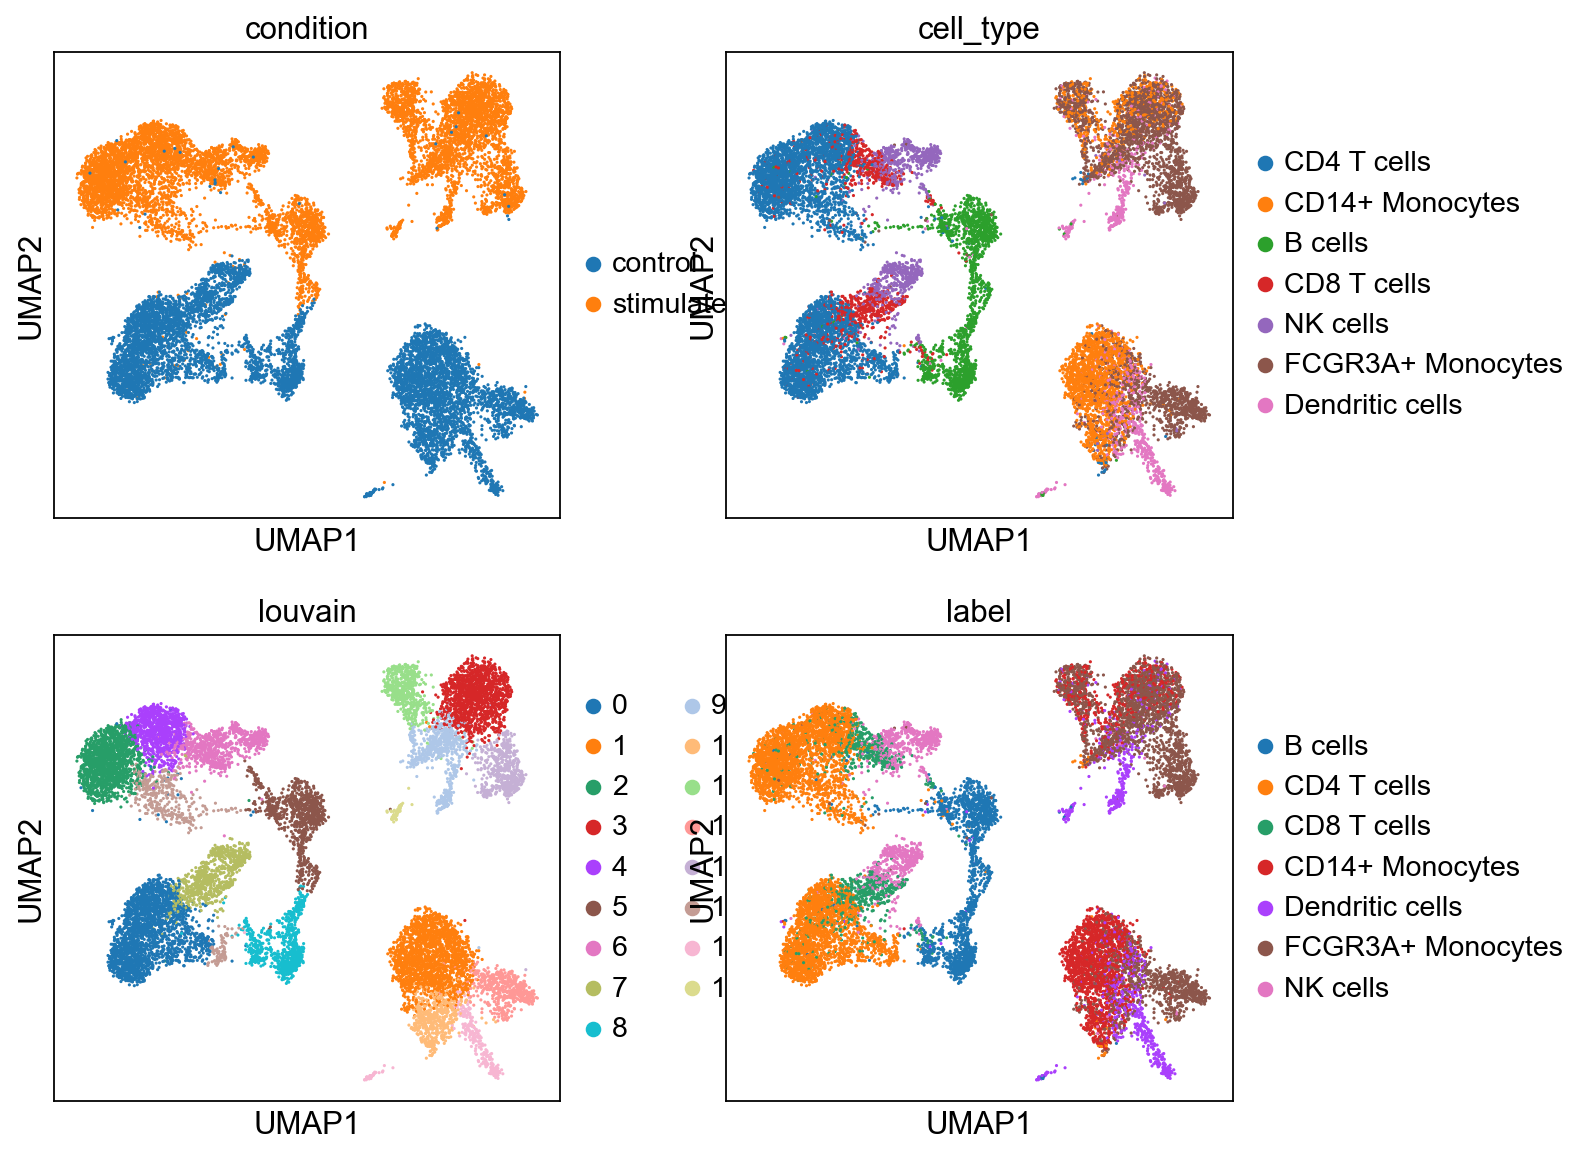

In [21]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(adata, ncols=2, 
           color=[
               "condition",
               "cell_type",
               "louvain",
               "label",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )

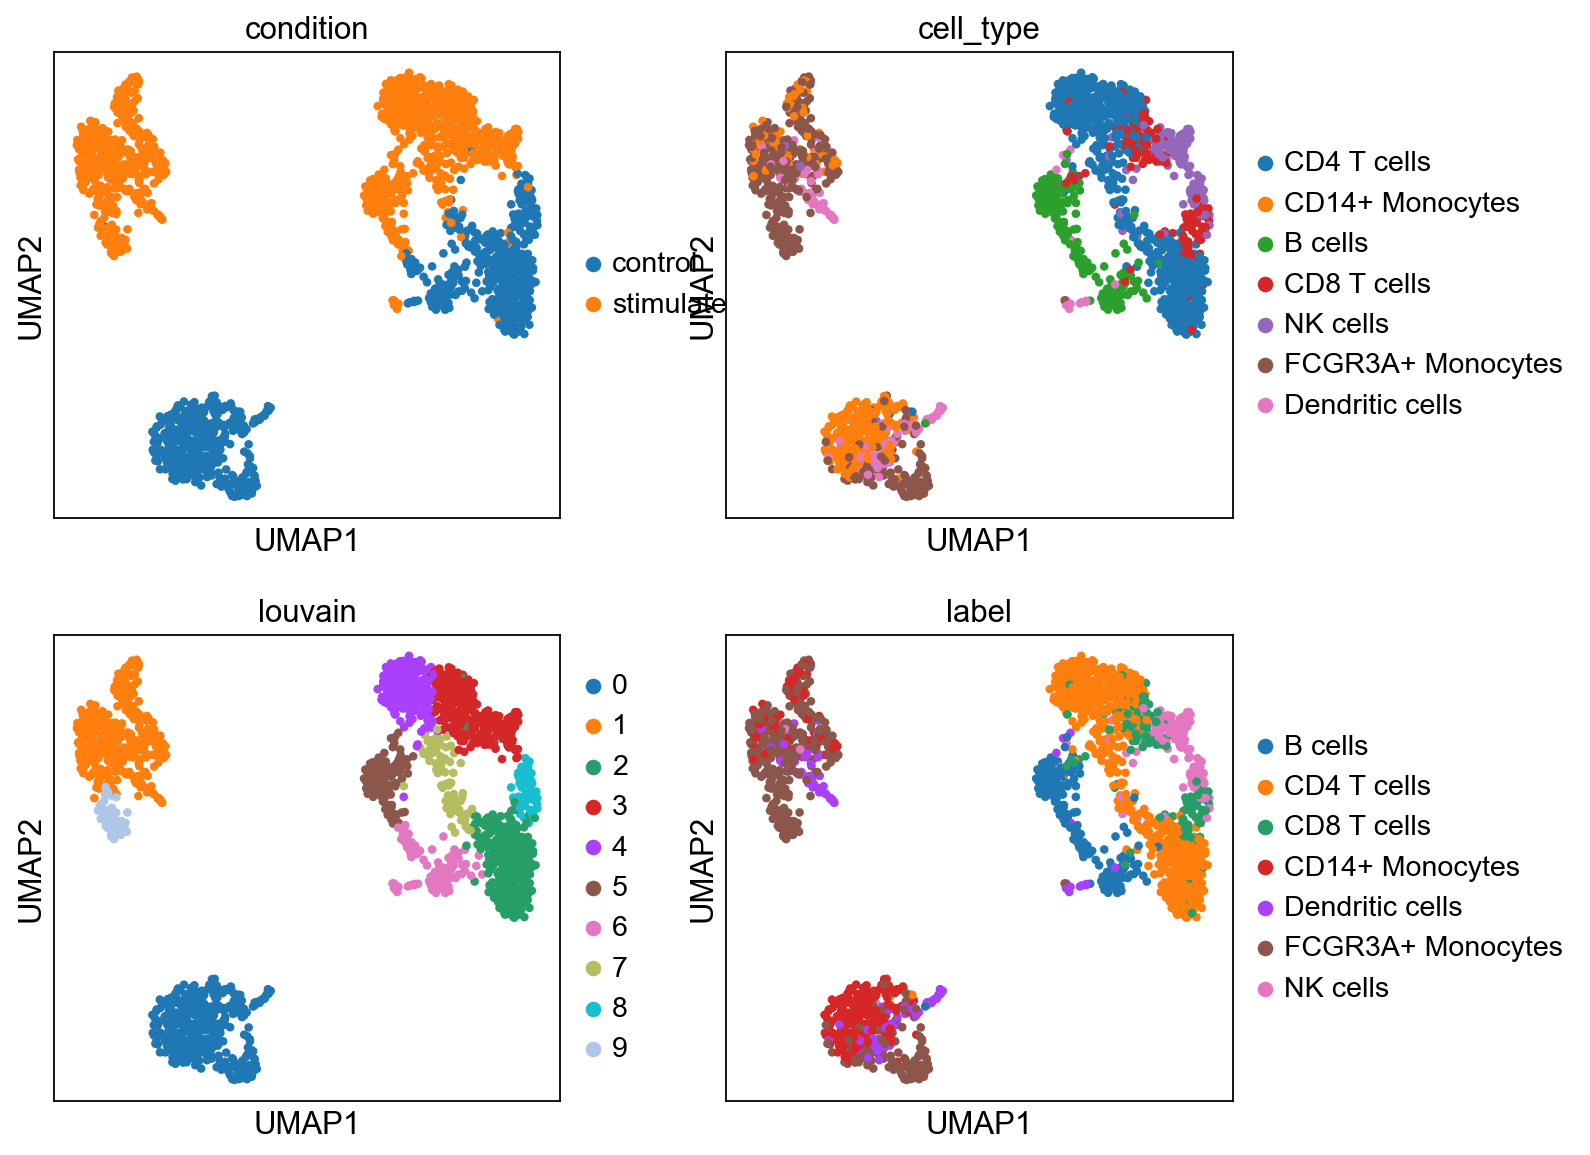

In [39]:
sc.pp.neighbors(bdata,)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "cell_type",
               "louvain",
               "label",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_test_set_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )

### Unconditioned and unsupervised GMM VAE model
We train a model and try to see if it can capture the modalities in an unsupervised training (which is unlikely)

In [179]:
reload(Mb0)
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xz(
        nx=adata.n_vars,
        nz=10,
        nw=10,
        nclasses=labels.shape[1]*3,
        concentration=1e0,
        dropout=0.15,
        bn=True,
        reclosstype="mse",
        restrict_w=True,
        restrict_z=True,
        #nc1=conditions.shape[1],
        #learned_prior=False,
        #learned_prior=True,
        )
model.apply(init_weights)
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                #conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xz'>


In [180]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=25,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        wt=1e-5,
        test_accuracy=True,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 1366.208740234375
loss_z: 15.351469039916992
loss_w: 5.592255592346191
loss_cluster: -0.20205055177211761
loss_d: 22.8680419921875
loss_y_alt: 1.8592538833618164
loss_y_alt2: 0
total_loss: 1411.8797607421875
num_clusters: 0

[ 0.  2. -1.  2.  0.  2. -1. -1.  0.  2. -1.  6.  5. -1.  2.  5.  2.  2.
  2. -1. -1.] 
 0.1000870044987692 
 [ 0.5         1.         -1.          0.5         0.66666667  0.54545455
 -1.         -1.          0.25        1.         -1.          1.
  0.375      -1.          0.61538462  0.5         0.38461538  0.76470588
  1.         -1.         -1.        ]
0.6033057851239669 

epoch's lr =  0.001
epoch 0
training phase
rec: 212.532958984375
loss_z: 3.327697515487671
loss_w: 0.39917317032814026
loss_cluster: -0.9729651212692261
loss_d: 0.4044526219367981
loss_y_alt: 2.657904624938965
loss_y_alt2: 0
total_loss: 219.32217407226562
num_clusters: 13

[ 2.  1.  2. -1.  5.  6.  2.  0. -1.  5.  2.  1. -1. -1. -1. -1.  0. -1.


In [181]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

[ 2.  1.  2. -1.  5.  6.  2.  0. -1.  5.  2.  5. -1. -1. -1. -1.  0. -1.
  6.  2. -1.] [ 0.96774194  0.77083333  0.64227642 -1.          0.67878788  0.79674797
  0.84722222  0.87121212 -1.          0.75091575  0.69444444  0.52666667
 -1.         -1.         -1.         -1.          0.8989899  -1.
  0.33333333  0.94117647 -1.        ] [186. 240. 123.  -1. 165. 123. 144. 132.  -1. 273. 108. 150.  -1.  -1.
  -1.  -1.  99.  -1.  36. 221.  -1.]
0.7795 0.74771911124782


In [182]:
model.cpu()
model.eval()
output = model(test_data, )
bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].argmax(-1).detach().numpy(),
#)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()

In [184]:
rec = output["rec"].detach()
torch.cosine_similarity(test_data, rec).mean()

tensor(0.7530)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'label' as categorical


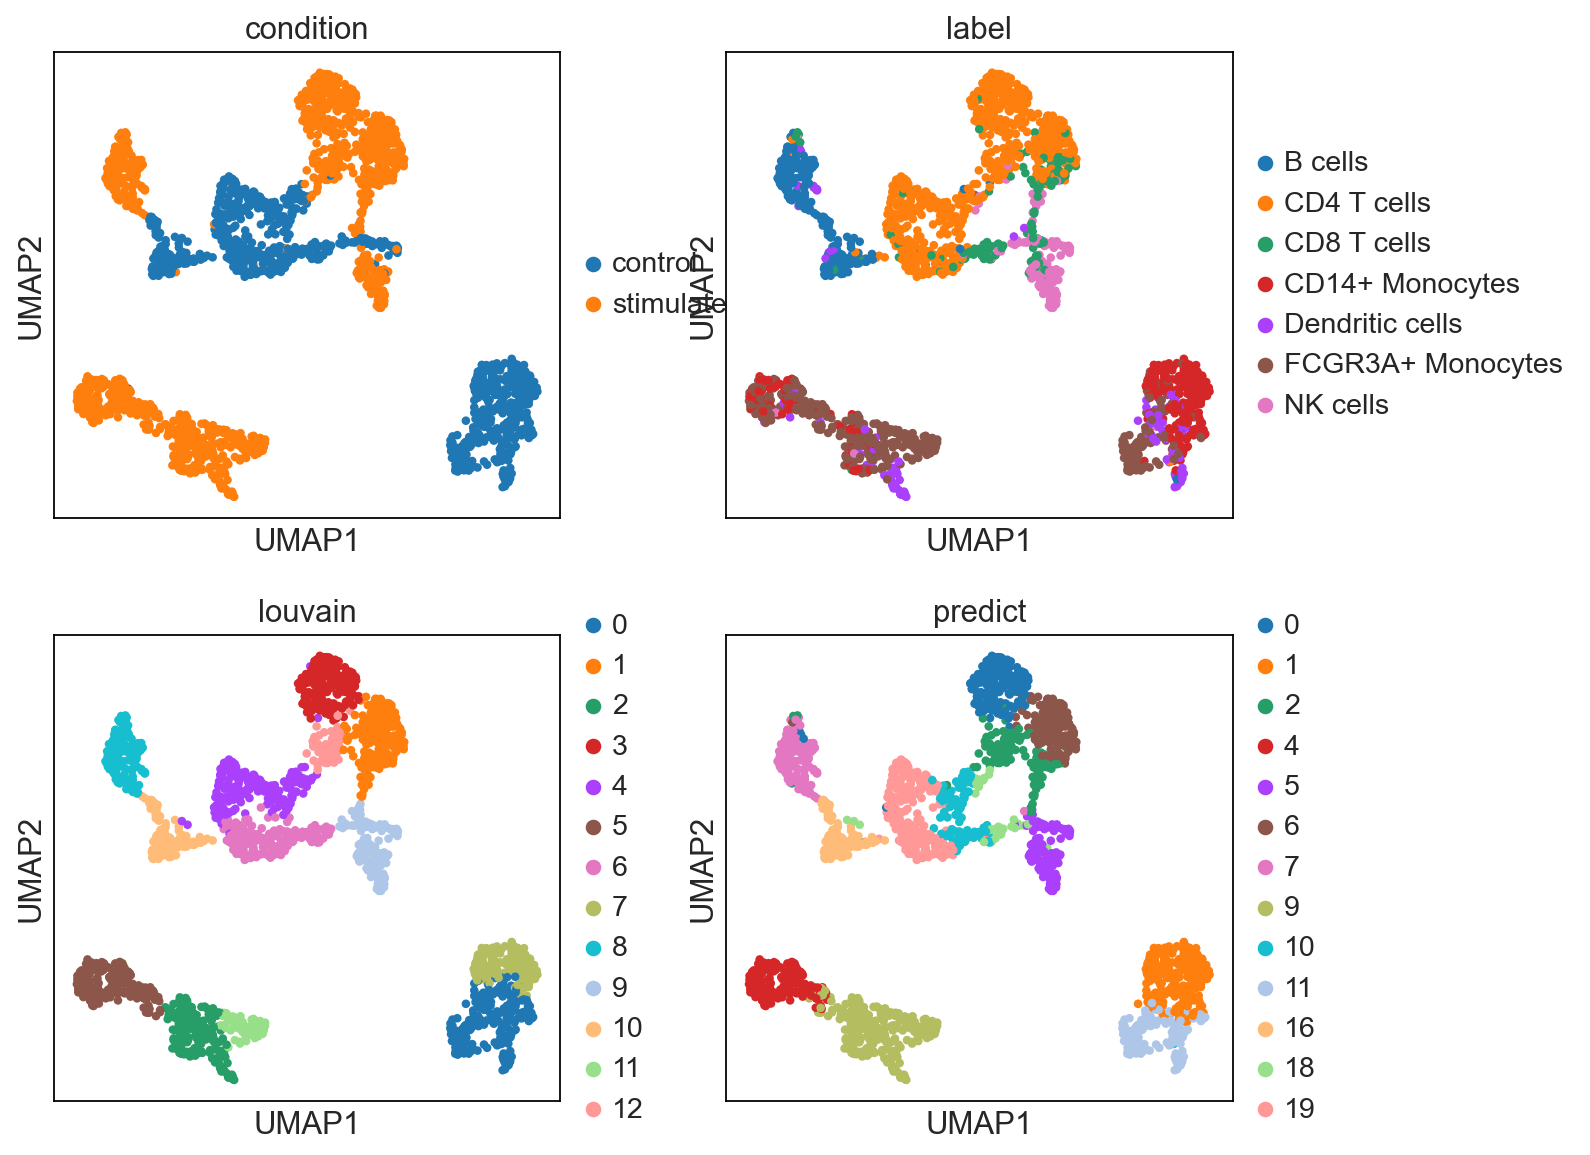

In [187]:
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_test_set_unsupervised_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )

### (Semi) Supervised GMM CVAE
We are going to train a GMM CVAE model using the condition (control/stimulated) and 
cell type information.
In this scenario we don't need to classify cell types but we are going to check if
the model can:

* generate synthetic data to simulate both cell type and condition
* "convert" real data from one condition to the other (e.g. control into stimulated state)
* obtain a 'nice' dimensional reduction in the latent space.

In [188]:
labeledSubset = ut.randomSubset(s=len(adata), r=0.45)
labeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data[labeledSubset],
                labels[labeledSubset],
                conditions[labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data[~labeledSubset],
                labels[~labeledSubset],
                conditions[~labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
test_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                test_data,
                test_labels,
                test_conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )
train_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)

x,y,c = train_loader.__iter__().next()
c.shape

torch.Size([128, 2])

In [189]:
reload(Mb0)
#model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzCv2(
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzC(
    nx=adata.n_vars,
    nz=10,
    nw=10,
    nclasses=labels.shape[1],
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    learned_prior=False,
    #learned_prior=True,
    #positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzC'>


In [190]:
Train.trainSemiSuperLoopCond(
        model,
        labeled_loader,
        unlabeled_loader,
        test_loader,
        num_epochs=50,
        report_interval=55,
        lrs = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        do_unlabeled=True,
        do_validation=True,
        test_accuracy=True,
        )

epoch 0
labeled phase
rec: 1362.204345703125
loss_z: 20.791135787963867
loss_w: 6.86700439453125
loss_cluster: -0.4054836332798004
loss_d: 6.819070339202881
loss_y_alt: 3.2246875762939453
loss_y_alt2: 2.2257285118103027
total_loss: 1402.132080078125
num_clusters: 4

[-1. -1.  2.  2.  2.  1. -1.] 
 -0.12976909073488552 
 [-1.         -1.          0.38095238  0.45714286  1.          0.25352113
 -1.        ]
0.368 

unlabeled phase
rec: 998.325927734375
loss_z: 15.739541053771973
loss_w: 5.930577754974365
loss_cluster: -0.546597421169281
loss_d: 4.265281677246094
loss_y_alt: 1.3308558464050293
loss_y_alt2: 0
total_loss: 1025.5921630859375
num_clusters: 6

eval phase
rec: 642.9383544921875
loss_z: 6.496088981628418
loss_w: 3.5951762199401855
loss_cluster: -0.7192736864089966
loss_d: 2.6719913482666016
loss_y_alt: 1.5777385234832764
loss_y_alt2: 0
total_loss: 657.2793579101562
num_clusters: 3
ce loss: -1.2401716709136963

done training
epoch 0
labeled phase
rec: 234.9712677001953
loss_z: 5.

In [191]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
#r,p,s = ut.estimateClusterImpurityLoop(model, data, labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())


[0. 1. 2. 3. 4. 5. 6.] [0.95833333 0.81506849 0.95568685 0.70714286 0.78571429 0.86332574
 0.91129032] [216. 292. 677. 140. 112. 439. 124.]
0.8855 0.8566516980010472


In [197]:
model.cpu()
model.eval()
output = model(test_data, cond1=test_conditions, y=test_labels)
#bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
bdata.obs["predict"] = test_enc_labels.inverse_transform(
    output["q_y"].argmax(-1).detach().numpy(),
)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
torch.cosine_similarity(test_data, rec).mean()

tensor(0.7539)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical


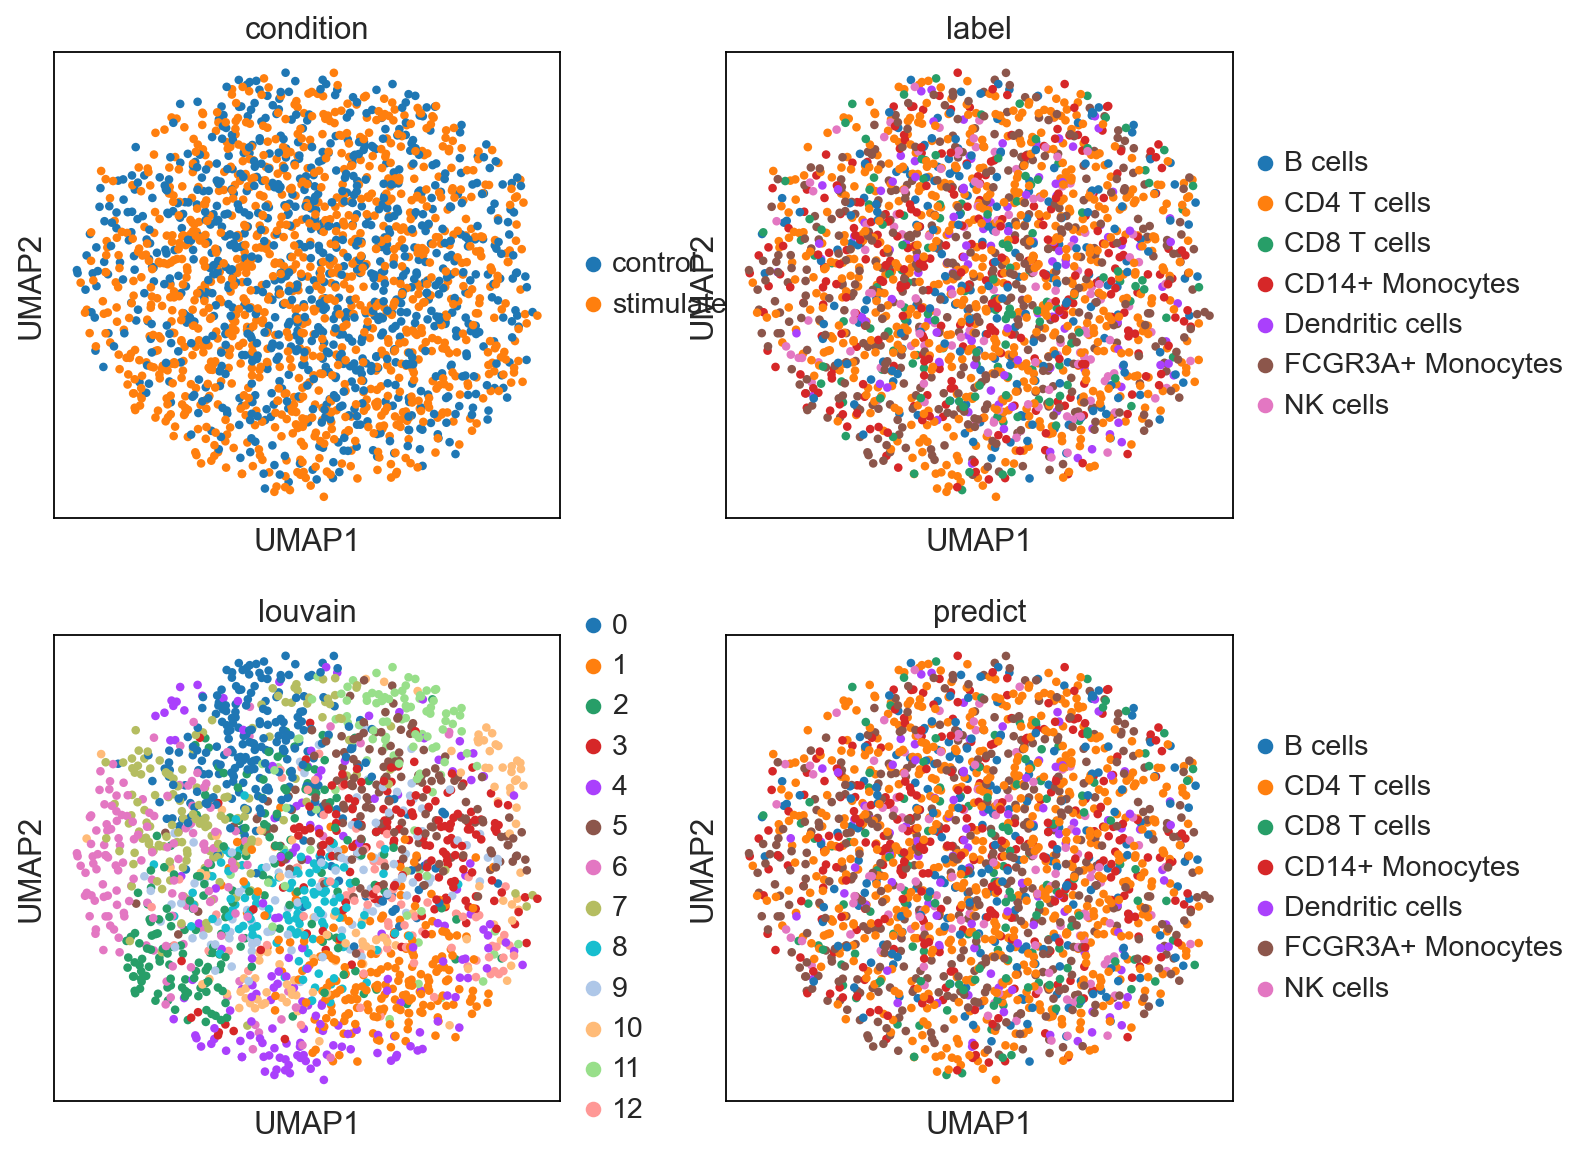

In [198]:
sc.pp.neighbors(bdata, use_rep="w",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_test_set_semisupervised_Kang_w_space.png",
           #show=True,
           #ax=ax,
          )

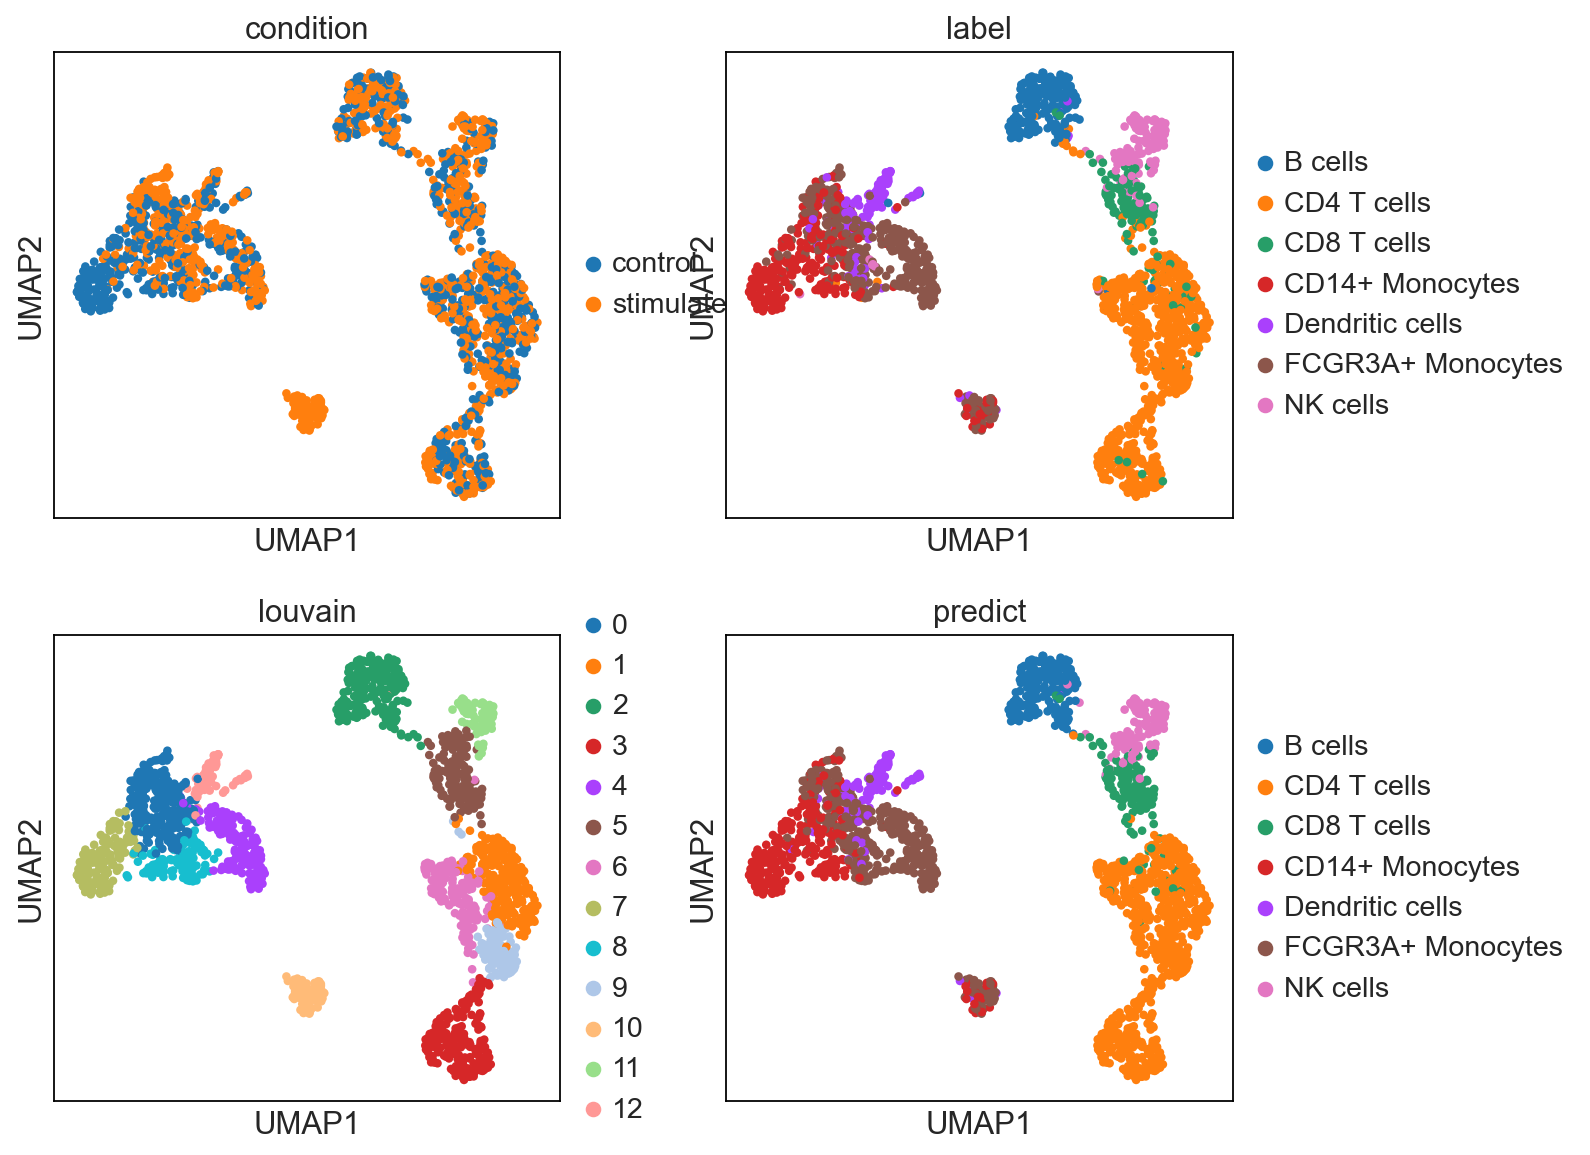

In [199]:
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_test_set_semisupervised_Kang_z_space.png",
           #show=True,
           #ax=ax,
          )


In [204]:
reload(ut)
ut.saveModelParameters(
        model,
        "./results/Kang_ss_batch_reduction_xzC" + ut.randomString() +  ut.timeStamp() + "model_params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/Kang_ss_batch_reduction_xzC" + ut.randomString() +  ut.timeStamp() + "model_state.pt",
        )


In [205]:
ut.loadModelParameter(
    "./results/Kang_ss_batch_reduction_xzC1662042390.151899model_params.pt",)

{'myName': "<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzC'>",
 'training': False,
 '_buffers': {},
 '_backward_hooks': {},
 '_is_full_backward_hook': None,
 '_forward_hooks': {},
 '_forward_pre_hooks': {},
 '_state_dict_hooks': {},
 '_load_state_dict_pre_hooks': {},
 'nx': 7000,
 'nh': 1024,
 'nhq': 1024,
 'nhp': 1024,
 'nz': 10,
 'nw': 10,
 'eps': 1e-09,
 'nclasses': 7,
 'numhidden': 2,
 'numhiddenq': 2,
 'numhiddenp': 2,
 'dscale': 1.0,
 'wscale': 1.0,
 'yscale': 1.0,
 'zscale': 1.0,
 'mi_scale': 1.0,
 'recloss_mii': 0,
 'concentration': 1.0,
 'relax': False,
 'restrict_w': True,
 'restrict_z': True,
 'softargmax': False,
 'use_resnet': False,
 'reclosstype': 'mse',
 'nc1': 2,
 'learned_prior': False}

In [207]:
reload(Mb0)
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzCv2(
    nx=adata.n_vars,
    nz=10,
    nw=10,
    nclasses=labels.shape[1],
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    learned_prior=False,
    #learned_prior=True,
    positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzCv2'>


In [208]:
Train.trainSemiSuperLoopCond(
        model,
        labeled_loader,
        unlabeled_loader,
        test_loader,
        num_epochs=50,
        report_interval=55,
        lrs = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        do_unlabeled=True,
        do_validation=True,
        test_accuracy=True,
        )

epoch 0
labeled phase
rec: 819.259033203125
loss_z: 17.716463088989258
loss_w: 5.500072002410889
loss_cluster: -0.367223858833313
loss_d: 4.166229248046875
loss_y_alt: 2.480473041534424
loss_y_alt2: 2.204484701156616
total_loss: 851.3267822265625
num_clusters: 4

[ 2. -1.  2.  2.  2.  5.  2.] 
 0.1560891023075897 
 [ 0.44444444 -1.          0.26666667  0.4         0.35294118  0.28571429
  0.34285714]
0.33858267716535434 

unlabeled phase
rec: 552.336181640625
loss_z: 13.084296226501465
loss_w: 4.684431552886963
loss_cluster: -0.5188665390014648
loss_d: 3.3919754028320312
loss_y_alt: 1.089321255683899
loss_y_alt2: 0
total_loss: 574.586181640625
num_clusters: 5

eval phase
rec: 422.51409912109375
loss_z: 6.1985273361206055
loss_w: 2.566542625427246
loss_cluster: -0.6689398884773254
loss_d: 1.726628065109253
loss_y_alt: 1.0750393867492676
loss_y_alt2: 0
total_loss: 434.080810546875
num_clusters: 3
ce loss: -0.9393869042396545

done training
epoch 0
labeled phase
rec: 216.5653076171875
los

In [209]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
#r,p,s = ut.estimateClusterImpurityLoop(model, data, labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6.] [0.9047619  0.7987013  0.95839525 0.68461538 0.79245283 0.87616822
 0.90322581] [231. 308. 673. 130. 106. 428. 124.]
0.88 0.8454743848841175


In [224]:
model.cpu()
model.eval()
output = model(test_data, cond1=test_conditions, y=test_labels, )
#bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
bdata.obs["predict"] = test_enc_labels.inverse_transform(
    output["q_y"].argmax(-1).detach().numpy(),
)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
torch.cosine_similarity(test_data, rec).mean()

tensor(0.7512)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predict' as categorical


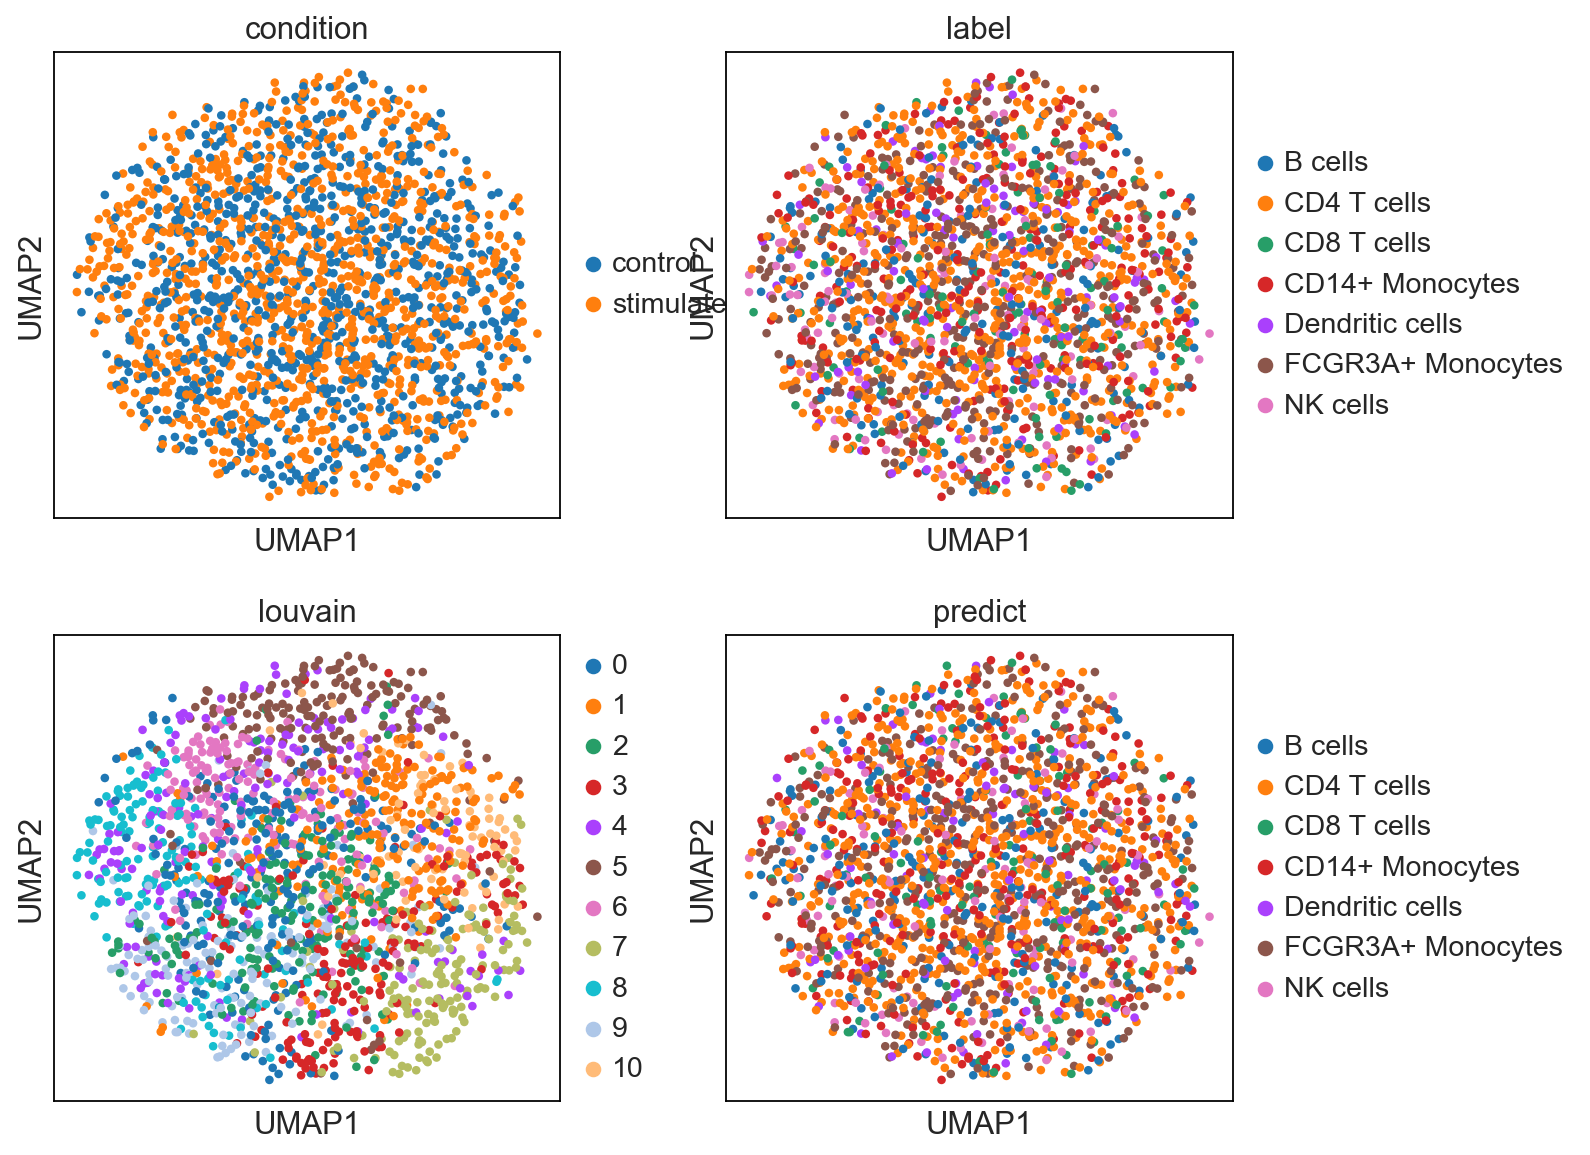

In [225]:
sc.pp.neighbors(bdata, use_rep="w",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_test_set_semisupervised_Kang_w_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )

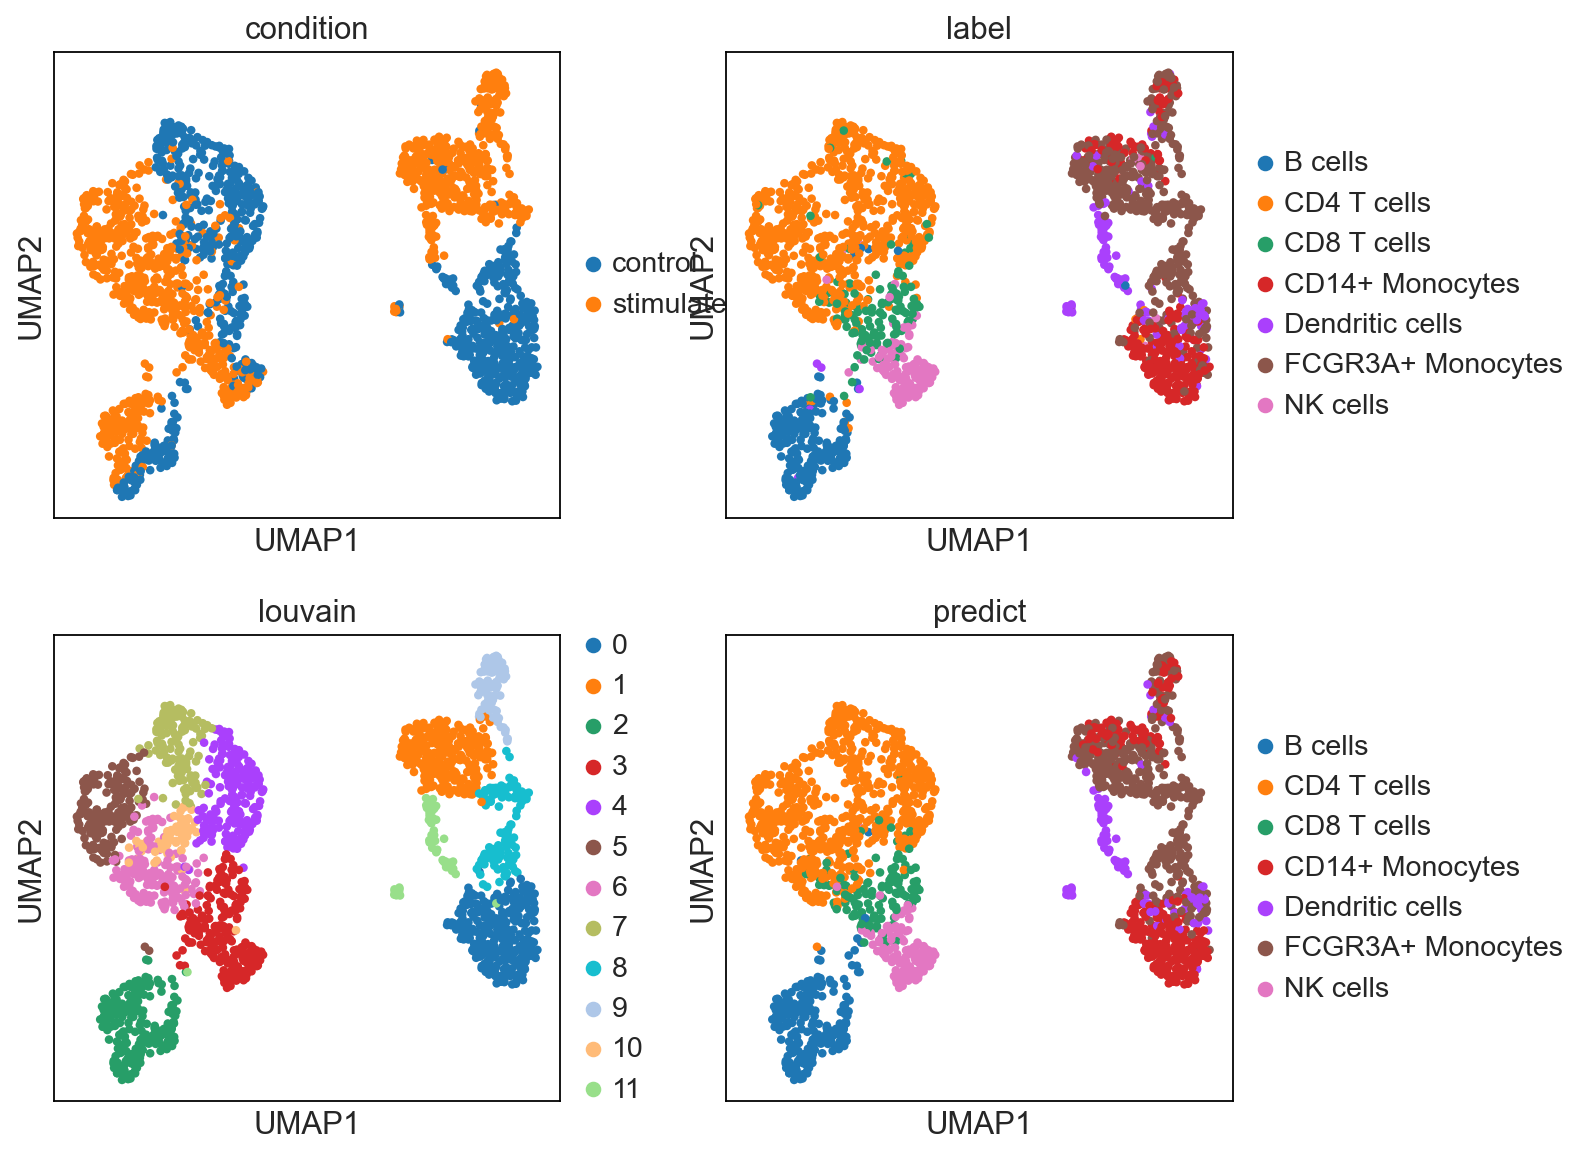

In [226]:
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
sc.pl.umap(bdata, ncols=2, 
           color=[
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_test_set_semisupervised_Kang_z_space_xzCvs.png",
           #show=True,
           #ax=ax,
          )

In [220]:
ut.saveModelParameters(
        model,
        "./results/Kang_ss_batch_reduction_xzCv2" + str(datetime.timestamp(datetime.now())) + "model_params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/Kang_ss_batch_reduction_xzCv2" + str(datetime.timestamp(datetime.now())) + "model_state.pt",
        )

## Simulating stimulation response

The idea here is to take as input the subset of control group cells of cell type X (in this case we will use
"CD14+ Monocytes"), but pass the stimulation condition instead of the control. we will then look at the reconstruction and 
see whether it is more symilar to the stimulation group then to the original control input.

We first test it with the last model we trained.

In [227]:
# set 'control' marker:
ctrlMaerker = bdata.obs["condition"] == "control"
# set B cells marker:
cd14Marker = bdata.obs["label"] == "CD14+ Monocytes"
#cd14Marker
#bdata.obs

In [228]:
cdata = bdata[ctrlMaerker & cd14Marker].copy()
cdata.obs

cell_type condition  mt_frac  n_counts  \
index                                                                      
GTAGTGACTGACCA-1-control-0  CD14+ Monocytes   control      0.0    1864.0   
ATAGCTCTCGCATA-1-control-0  CD14+ Monocytes   control      0.0    1416.0   
AGCATCGAGCCCTT-1-control-0  CD14+ Monocytes   control      0.0    2946.0   
CACGGGACGGATCT-1-control-0  CD14+ Monocytes   control      0.0    2162.0   
TTCATTCTACAGCT-1-control-0  CD14+ Monocytes   control      0.0    2175.0   
...                                     ...       ...      ...       ...   
TATGTCACTCGTAG-1-control-0  CD14+ Monocytes   control      0.0    3059.0   
TCACTATGCTTCTA-1-control-0  CD14+ Monocytes   control      0.0    2131.0   
CTTGAGGATAGCCA-1-control-0  CD14+ Monocytes   control      0.0    2410.0   
CATGTTACTGTCTT-1-control-0  CD14+ Monocytes   control      0.0    3180.0   
CGGCATCTTAAAGG-1-control-0  CD14+ Monocytes   control      0.0    2303.0   

                            n_genes  percent_mito       study  \
index                                                           
GTAGTGACTGACCA-1-control-0      564           NaN  Kang et al   
ATAGCTCTCGCATA-1-control-0      517           NaN  Kang et al   
AGCATCGAGCCCTT-1-control-0      841           NaN  Kang et al   
CACGGGACGGATCT-1-control-0      770           NaN  Kang et al   
TTCATTCTACAGCT-1-control-0      625           NaN  Kang et al   
...                             ...           ...         ...   
TATGTCACTCGTAG-1-control-0      865           NaN  Kang et al   
TCACTATGCTTCTA-1-control-0      729           NaN  Kang et al   
CTTGAGGATAGCCA-1-control-0      758           NaN  Kang et al   
CATGTTACTGTCTT-1-control-0     1067           NaN  Kang et al   
CGGCATCTTAAAGG-1-control-0      735           NaN  Kang et al   

                                    predict louvain            label  
index                                                                 
GTAGTGACTGACCA-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
ATAGCTCTCGCATA-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
AGCATCGAGCCCTT-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
CACGGGACGGATCT-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
TTCATTCTACAGCT-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
...                                     ...     ...              ...  
TATGTCACTCGTAG-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
TCACTATGCTTCTA-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
CTTGAGGATAGCCA-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  
CATGTTACTGTCTT-1-control-0  Dendritic cells       0  CD14+ Monocytes  
CGGCATCTTAAAGG-1-control-0  CD14+ Monocytes       0  CD14+ Monocytes  

[219 rows x 10 columns]

In [235]:
model.cpu()
model.eval()
simOutput = model(
    input=test_data[ctrlMaerker & cd14Marker],
    y=test_labels[ctrlMaerker & cd14Marker],
    cond1=1-test_conditions[ctrlMaerker & cd14Marker],
)

In [236]:
cdata.X = simOutput['rec'].detach().abs().numpy()
cdata.obsm["z"] = simOutput["mu_z"].detach().numpy()
cdata.obsm["mu_z"] = simOutput["mu_z"].detach().numpy()
cdata.obsm["mu_w"] = simOutput["mu_w"].detach().numpy()
cdata.obsm["w"] = simOutput["w"].detach().numpy()
cdata.obs["sim"] = "simulated"
bdata.obs["sim"] = bdata.obs["condition"].copy()

In [237]:
xdata = ad.concat([bdata, cdata], label="set", join="inner",)
xdata.var_names_make_unique()
xdata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [238]:
sc.pp.neighbors(xdata,use_rep="mu_z")
sc.tl.umap(xdata, )
sc.tl.louvain(xdata,)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

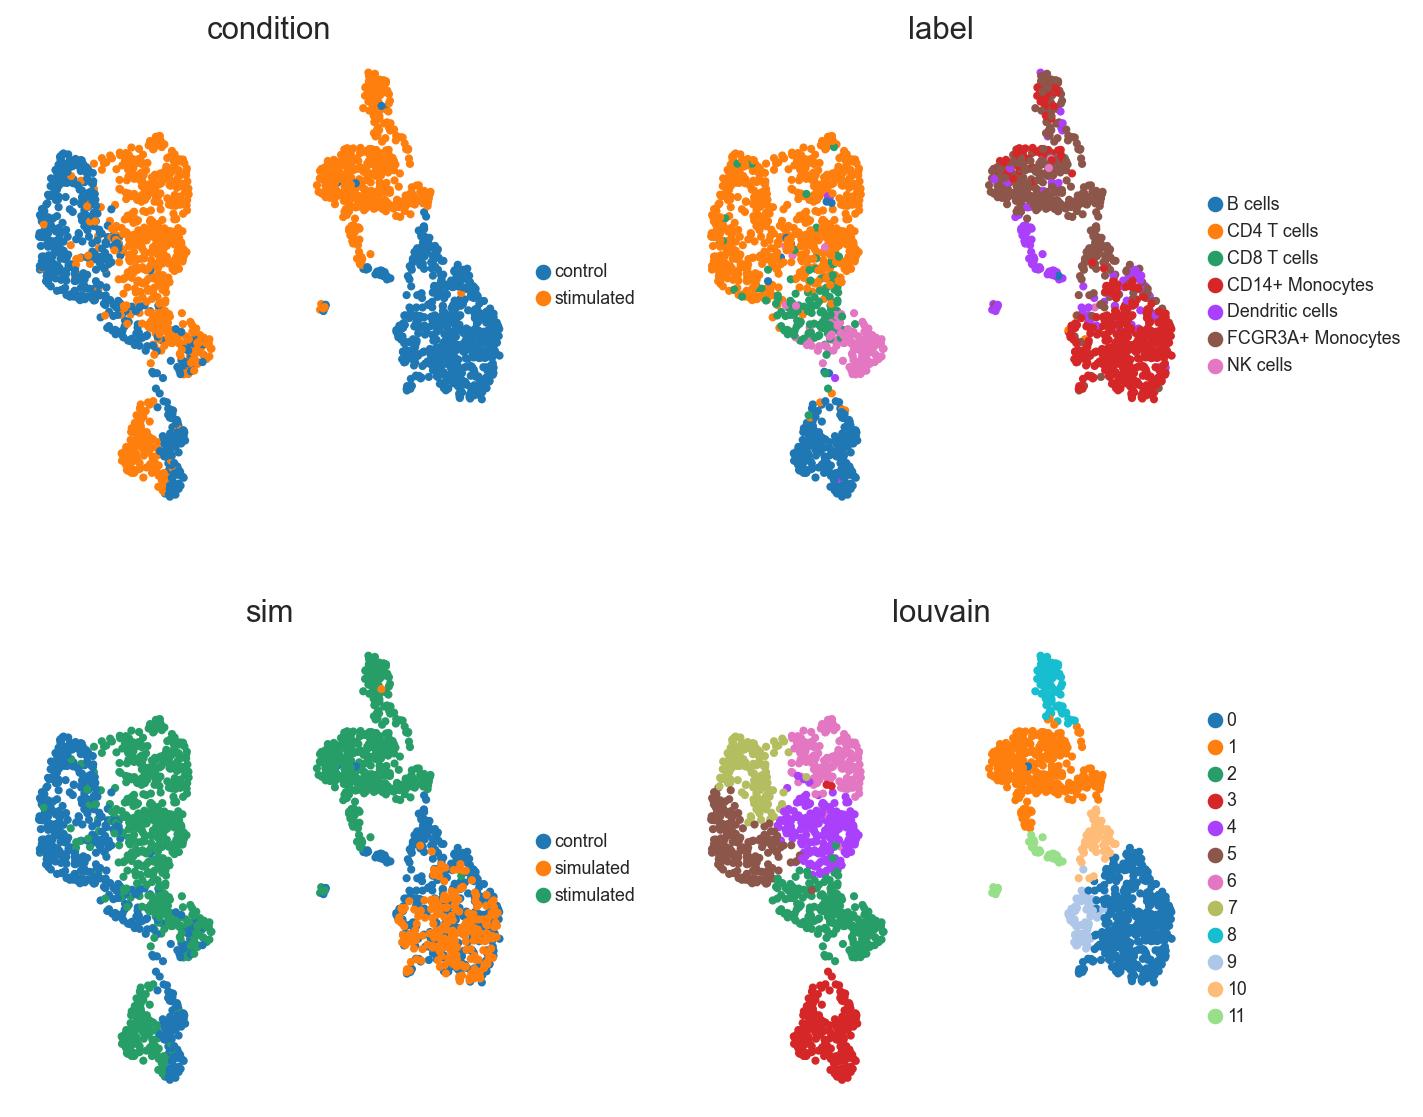

In [239]:
#sc.pl.umap(bdata,
#           color=[
#               "condition",
#               "label",
#               "sim",
#               "louvain",
#           ], 
#           frameon=False,
#           #legend_loc='on data',
#           legend_fontsize=8,
#           ncols=2,
#           #color_map="magma",
#           #save="Kang_simulated_response_cd14_z_space.png",
#          )
sc.pl.umap(xdata,
           color=[
               "condition",
               "label",
               "sim",
               "louvain",
           ], 
           frameon=False,
           #legend_loc='on data',
           legend_fontsize=8,
           ncols=2,
           #color_map="magma",
           save="Kang_simulated_response_cd14_z_space.png",
          )

so in the latent $z$ space the simulated response 
is a new cluster, detached from the original control cluster, and somewhat neighboring the grouping of 
the original response cd14 cells (which aren't really clustered they are mixed in with the brown cells).
Next we look at the change in the original expression + additon of the reconstruction.

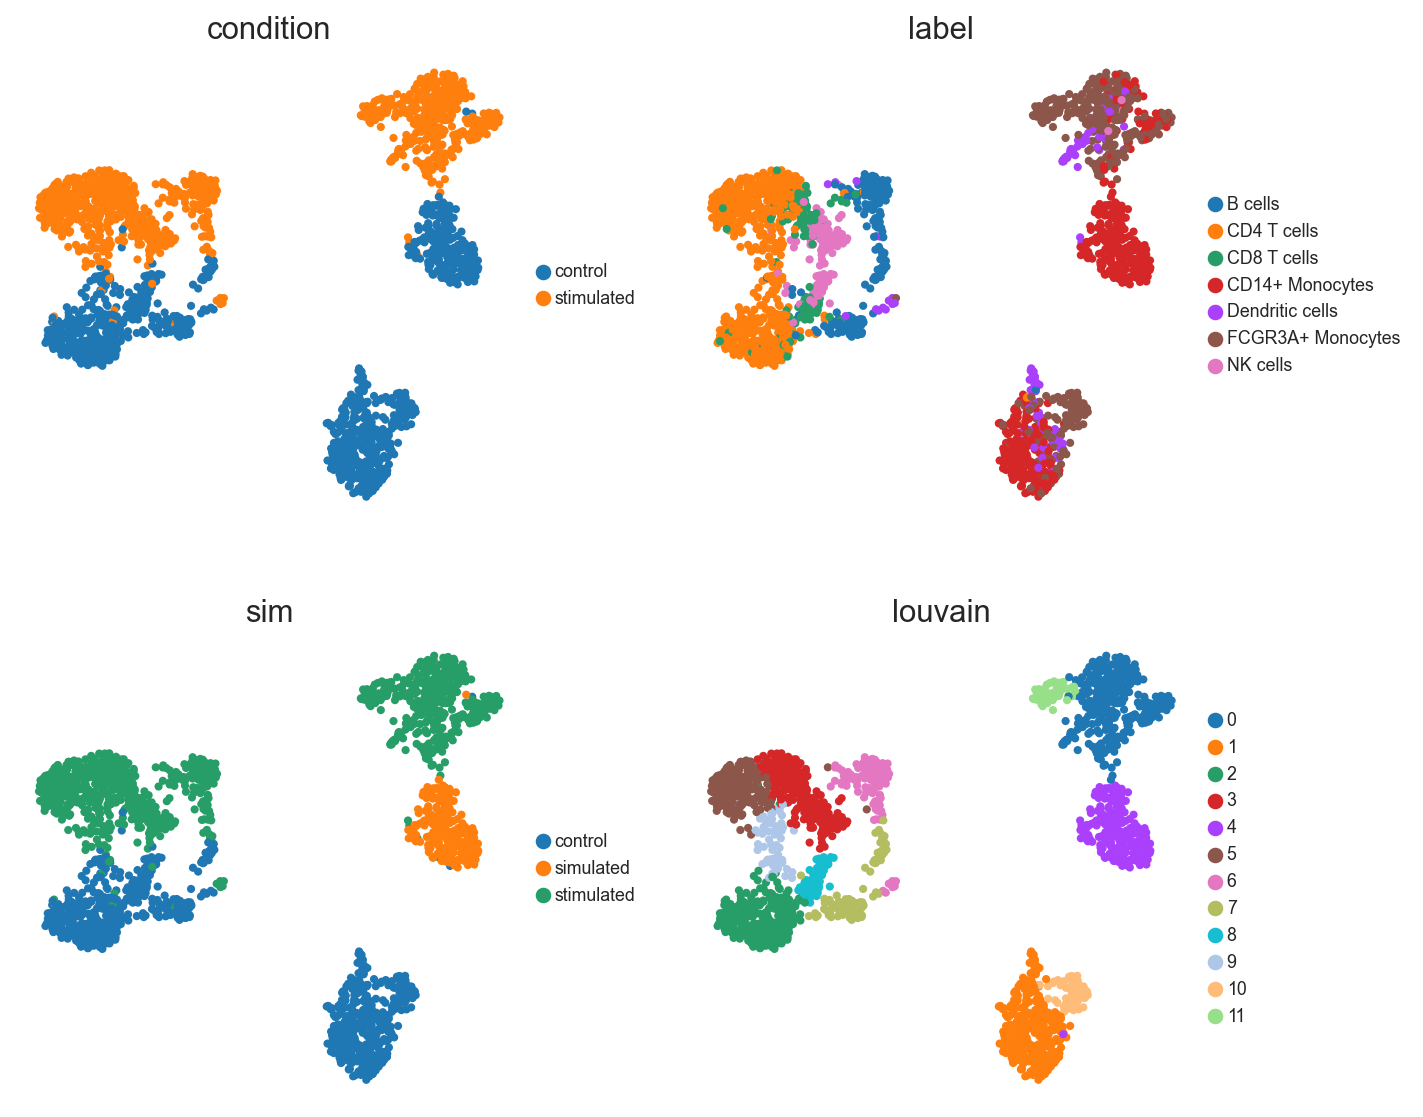

In [240]:
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata,)
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)
sc.pl.umap(xdata,
           color=[
               "condition",
               "label",
               "sim",
               "louvain",
           ], 
           frameon=False,
           #legend_loc='on data',
           legend_fontsize=8,
           ncols=2,
           #color_map="magma",
           save="Kang_simulated_response_cd14_pca_space.png",
          )

The above shows a umap of the test dataset with the addition of the "simulated" reconstruction.
Here we see that the cd14 cells with the symulated response, are mapped into a different cluster, one which neighbors or at least semms closer to the
real stimulated cd14 cells and far from the original input.

Next we will compare regression correlation coefficient ($R^2$) of between each pair from the following groups:
mean expression of the control cd14 group, mean expression of the stimulated cd14, mean expression of the "simulated" stimulated group.

In [241]:
cd14Ctrl = test_data[ctrlMaerker & cd14Marker].detach()
cd14ResponseData = test_data[(~ctrlMaerker) & cd14Marker].detach()
cd14SimData = simOutput['rec'].detach().abs() 

In [242]:
stats.linregress(
    cd14Ctrl .mean(0),
    cd14ResponseData.mean(0),
    #cd14SimData .mean(0),
)

LinregressResult(slope=0.9121589905367037, intercept=0.00754189267140469, rvalue=0.7922619373313641, pvalue=0.0, stderr=0.008397955359846778, intercept_stderr=0.0016557095541013605)

In [243]:
stats.linregress(
    cd14Ctrl .mean(0),
    #cd14ResponseData.mean(0),
    cd14SimData.mean(0),
)

LinregressResult(slope=0.8962816154459078, intercept=-0.006257458489617777, rvalue=0.9124029449264771, pvalue=0.0, stderr=0.0048062382526390035, intercept_stderr=0.0009475800064656472)

In [244]:
stats.linregress(
    #cd14Ctrl .mean(0),
    cd14ResponseData.mean(0),
    cd14SimData .mean(0),
)

LinregressResult(slope=0.7769969616387075, intercept=-0.0030654473762251264, rvalue=0.9106746805800677, pvalue=0.0, stderr=0.004213565530795513, intercept_stderr=0.0009524609577725433)

So ctrl vs response have r-value of 0.79, 
ctrl vs simulation (the reconstruction of ctrl with switched condition) has r-value of 0.907,
and response vs simulation have a slightly higher value of 0.91.
Not shown here, but had we tried ctrl vs ctrl_rec (reconstruction without switching conditioned) we would get  r-value of 0.99.

Bottom line: by switching the condition information from control to stimulated, on the ctrl as input, we get a reconstruction that
is more correlated to the real response data, but still almost equally correlated to the original ctrl input.

In [245]:
ydata = xdata[xdata.obs["label"] == "CD14+ Monocytes"].copy()
#ydata.obs["sim"]
#ydata.obs

In [246]:
sc.tl.rank_genes_groups(ydata, groupby="sim", method="wilcoxon")

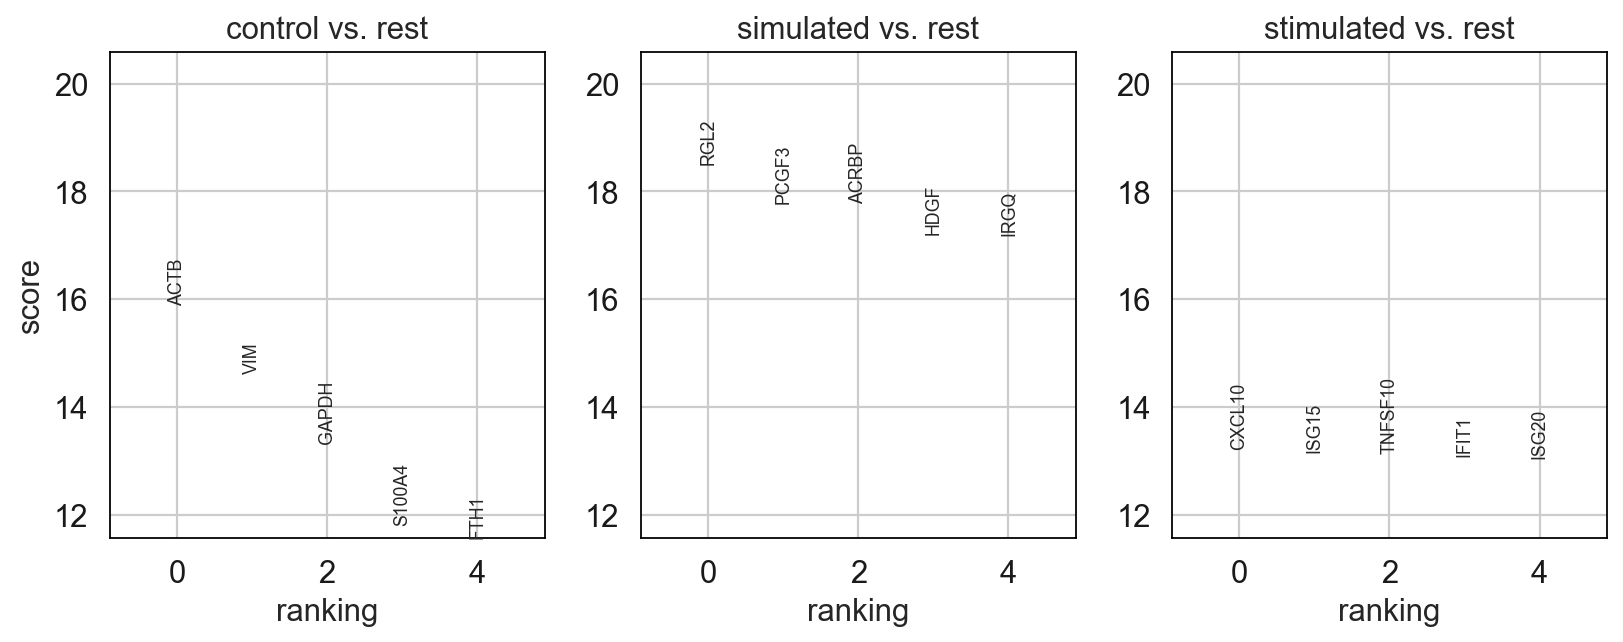

In [247]:
sc.pl.rank_genes_groups(ydata, n_genes=5, cmap="viridis",)

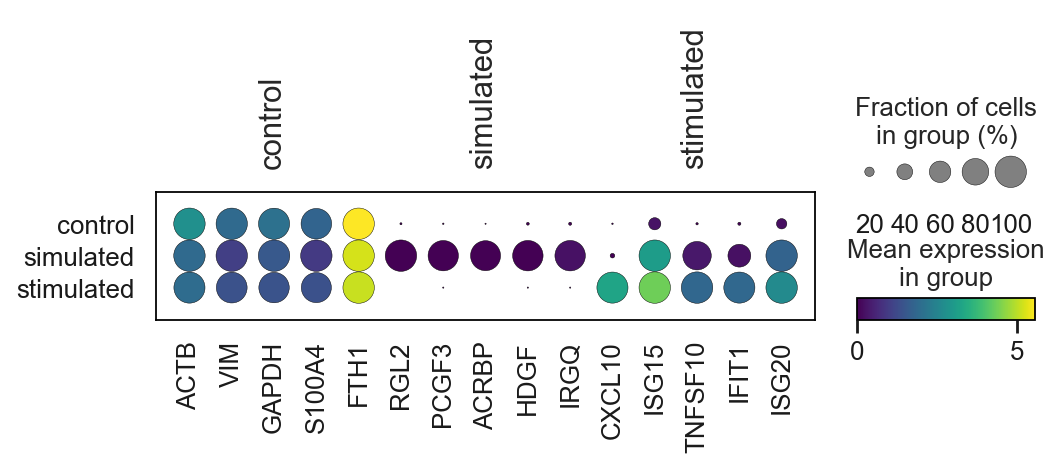

In [248]:
sc.pl.rank_genes_groups_dotplot(
    ydata,
    n_genes=5,
    cmap="viridis",
    dendrogram=False,
    save="Kang_simulated_response_cd14_ranked_genes.png",
)

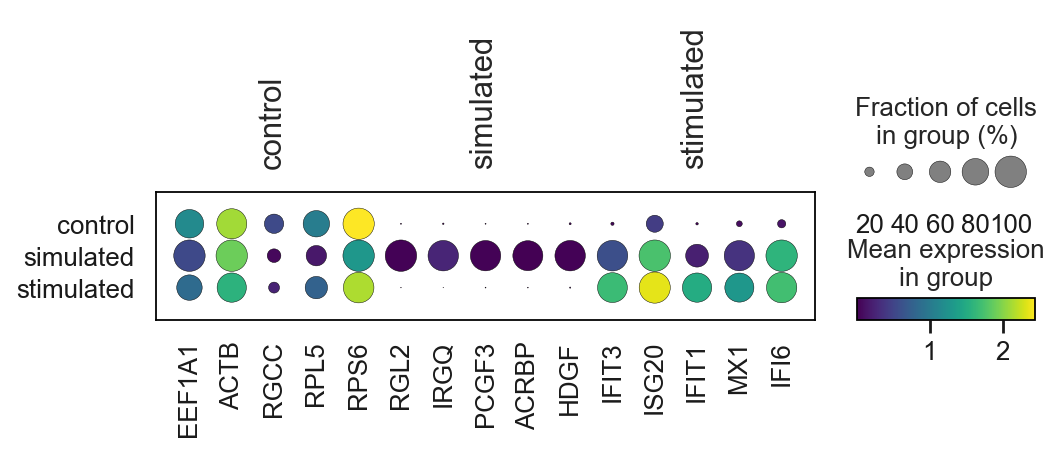

In [249]:
sc.tl.rank_genes_groups(xdata, groupby="sim", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(xdata, n_genes=5, cmap="viridis", dendrogram=False,)

In [250]:
temp = zip(list( xdata.obs["label"]), ["_"]*xdata.n_vars, list(xdata.obs["sim"]) )
temp = zip(xdata.obs["sim"], [" "]*xdata.n_vars, xdata.obs["label"], )
temp = [x+y+z for (x,y,z) in temp]
xdata.obs["cond+type"] = temp
xdata.obs

cell_type   condition  mt_frac  \
index                                                                   
GACAGGGAATCTTC-1-control-0     FCGR3A+ Monocytes     control      0.0   
GTAGTGACTGACCA-1-control-0       CD14+ Monocytes     control      0.0   
CTTGATTGACTACG-1-control-0           CD4 T cells     control      0.0   
CGCAGGTGACGCTA-1-control-0     FCGR3A+ Monocytes     control      0.0   
TGGCACCTGGTAGG-1-stimulated-0  FCGR3A+ Monocytes  stimulated      0.0   
...                                          ...         ...      ...   
TATGTCACTCGTAG-1-control-0-1     CD14+ Monocytes     control      0.0   
TCACTATGCTTCTA-1-control-0-1     CD14+ Monocytes     control      0.0   
CTTGAGGATAGCCA-1-control-0-1     CD14+ Monocytes     control      0.0   
CATGTTACTGTCTT-1-control-0-1     CD14+ Monocytes     control      0.0   
CGGCATCTTAAAGG-1-control-0-1     CD14+ Monocytes     control      0.0   

                               n_counts  n_genes  percent_mito       study  \
index                                                                        
GACAGGGAATCTTC-1-control-0       4132.0     1235           NaN  Kang et al   
GTAGTGACTGACCA-1-control-0       1864.0      564           NaN  Kang et al   
CTTGATTGACTACG-1-control-0       2178.0      762           NaN  Kang et al   
CGCAGGTGACGCTA-1-control-0       1721.0      823           NaN  Kang et al   
TGGCACCTGGTAGG-1-stimulated-0    2174.0      671           NaN  Kang et al   
...                                 ...      ...           ...         ...   
TATGTCACTCGTAG-1-control-0-1     3059.0      865           NaN  Kang et al   
TCACTATGCTTCTA-1-control-0-1     2131.0      729           NaN  Kang et al   
CTTGAGGATAGCCA-1-control-0-1     2410.0      758           NaN  Kang et al   
CATGTTACTGTCTT-1-control-0-1     3180.0     1067           NaN  Kang et al   
CGGCATCTTAAAGG-1-control-0-1     2303.0      735           NaN  Kang et al   

                                         predict louvain              label  \
index                                                                         
GACAGGGAATCTTC-1-control-0       Dendritic cells       1  FCGR3A+ Monocytes   
GTAGTGACTGACCA-1-control-0       CD14+ Monocytes       1    CD14+ Monocytes   
CTTGATTGACTACG-1-control-0           CD4 T cells       2        CD4 T cells   
CGCAGGTGACGCTA-1-control-0           CD4 T cells       9  FCGR3A+ Monocytes   
TGGCACCTGGTAGG-1-stimulated-0  FCGR3A+ Monocytes       0  FCGR3A+ Monocytes   
...                                          ...     ...                ...   
TATGTCACTCGTAG-1-control-0-1     CD14+ Monocytes       4    CD14+ Monocytes   
TCACTATGCTTCTA-1-control-0-1     CD14+ Monocytes       4    CD14+ Monocytes   
CTTGAGGATAGCCA-1-control-0-1     CD14+ Monocytes       4    CD14+ Monocytes   
CATGTTACTGTCTT-1-control-0-1     Dendritic cells       4    CD14+ Monocytes   
CGGCATCTTAAAGG-1-control-0-1     CD14+ Monocytes       4    CD14+ Monocytes   

                                      sim set                     cond+type  
index                                                                        
GACAGGGAATCTTC-1-control-0        control   0     control FCGR3A+ Monocytes  
GTAGTGACTGACCA-1-control-0        control   0       control CD14+ Monocytes  
CTTGATTGACTACG-1-control-0        control   0           control CD4 T cells  
CGCAGGTGACGCTA-1-control-0        control   0     control FCGR3A+ Monocytes  
TGGCACCTGGTAGG-1-stimulated-0  stimulated   0  stimulated FCGR3A+ Monocytes  
...                                   ...  ..                           ...  
TATGTCACTCGTAG-1-control-0-1    simulated   1     simulated CD14+ Monocytes  
TCACTATGCTTCTA-1-control-0-1    simulated   1     simulated CD14+ Monocytes  
CTTGAGGATAGCCA-1-control-0-1    simulated   1     simulated CD14+ Monocytes  
CATGTTACTGTCTT-1-control-0-1    simulated   1     simulated CD14+ Monocytes  
CGGCATCTTAAAGG-1-control-0-1    simulated   1     simulated CD14+ Monocytes  

[2219 rows x 13 columns]

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cond+type' as categorical


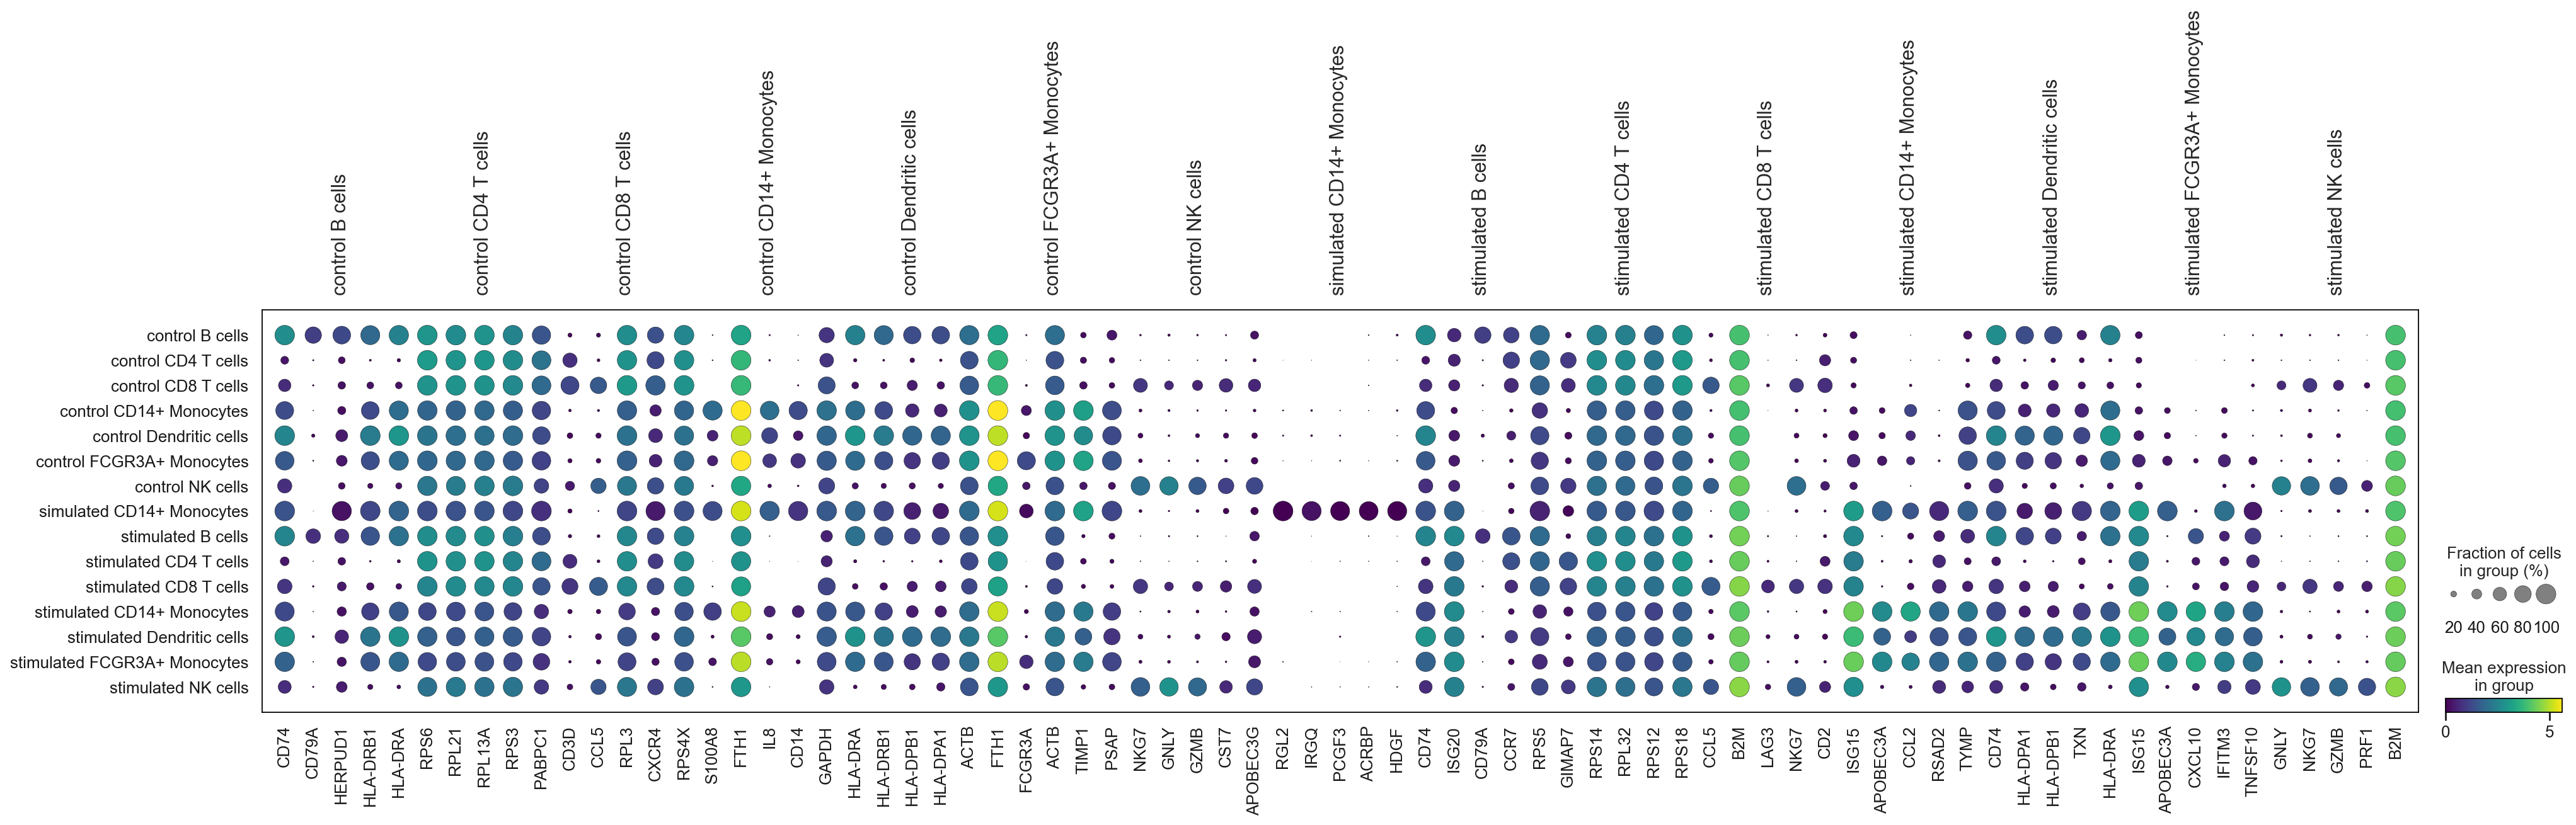

In [251]:
sc.tl.rank_genes_groups(xdata, groupby="cond+type", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(xdata, n_genes=5, cmap="viridis", dendrogram=False,)

When it comes to identifying marker genes in the simulated group we have a problem. I think the reason is that there are some genes
that in the real data are almost everywhere $0$, whereas in the simulated data, they are almost everywhere within some small positive
range, or perhaps the other way around.

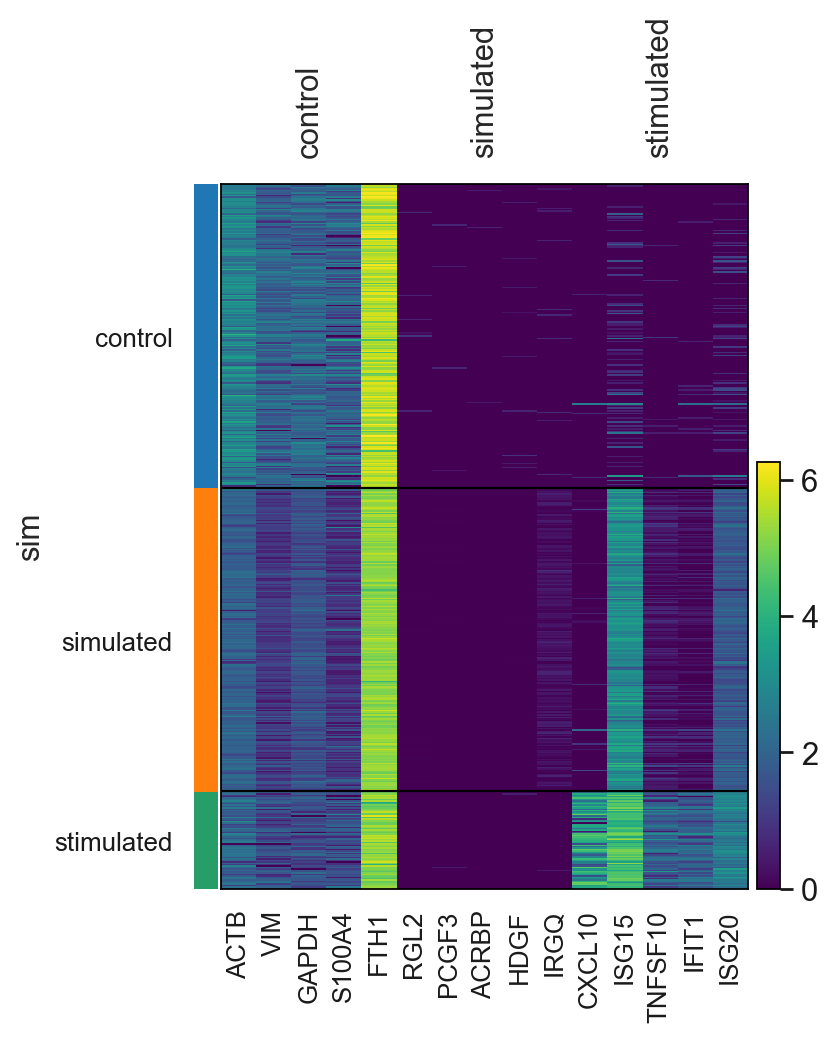

In [252]:
sc.pl.rank_genes_groups_heatmap(ydata,
                                n_genes=5,
                                cmap="viridis",
                                dendrogram=False,
                                save="Kang_simulated_response_cd14_ranked_genes_heatmap.png",
                               )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


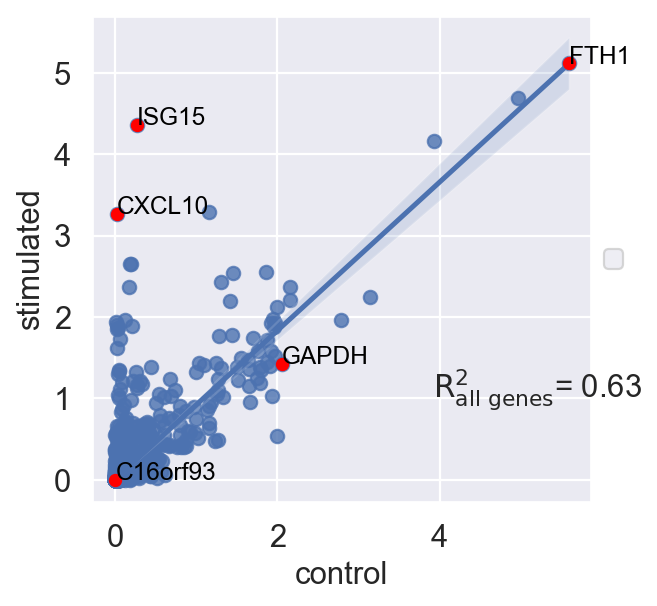

0.6276789945936868

In [253]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "control", "y" : "stimulated"},
                 labels={"x" : "control", "y" : "stimulated"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_ctrl_resp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


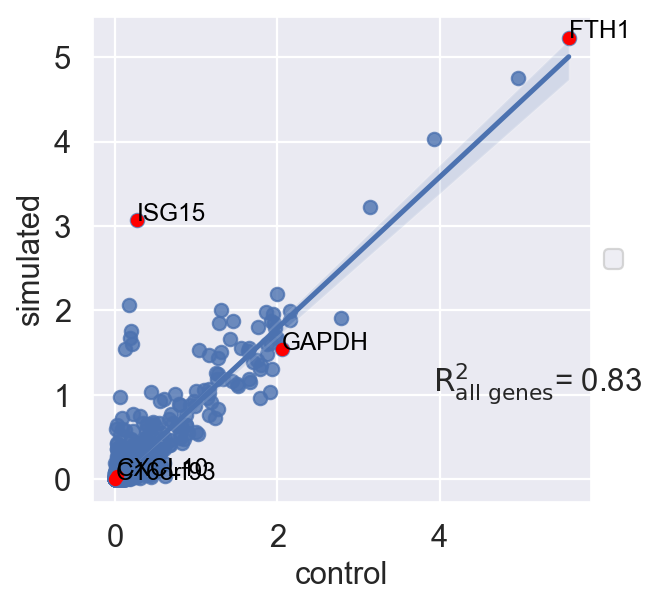

0.832479110510814

In [254]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "control", "y" : "simulated"},
                 labels={"x" : "control", "y" : "simulated"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_ctrl_simresp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


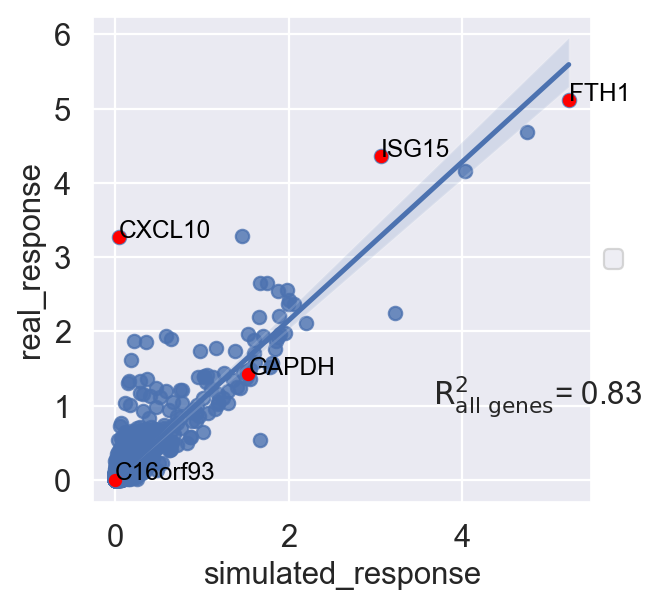

0.8293283996781585

In [255]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "simulated", "y" : "stimulated"},
                 labels={"x" : "simulated_response", "y" : "real_response"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_resp_simresp.png",
                )

# Generation
So now we don't use any input, but test the capability of the model to generate synthetic data that looks like 
a specific cell type (cd14) with a specific condition (ctrl vs stimulated).

In [256]:
#w = bdata.obsm["w"].mean(0,) + torch.randn(80, model.nw).numpy() * bdata.obsm["w"].std(0,)
w = torch.randn(80, model.nw)
c = torch.zeros(80,2)
c[:40,0] = 1
c[40:,1] = 1
#c
#w.mean()
#w.var()
#w.shape
#w = torch.tensor(w)

In [257]:
test_enc_labels.classes_
# cd14+ are cat=1

array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells'], dtype=object)

In [258]:
# cd14 cells is category=1, take only the mu part from the last dim
z = model.Pz(
    torch.cat([w,c], dim=1),)[:,1,:model.nz]
rec = model.Px(
    torch.cat([z,c], dim=1),)
rec.shape

torch.Size([80, 7000])

In [259]:
ddata = sc.AnnData(
    X = rec.detach().numpy(),
    obs = {
        "condition" : 40*["control"] + 40*["stimulated"],
        "sim" : 40*["gen_control"] + 40*["gen_stimulated"],
        "label" : 40 * ["(generated control) CD14+"] + 40*["(generated response) CD14+"],
        #"label" : 80 * ["(generated) CD14+"],
    },
    obsm = {
        "z" : z.detach().numpy(),
        "w" : w.detach().numpy(),
    },
    var = {
        "var_names" : bdata.var_names,
    }
)

In [260]:
xxdata = ad.concat([bdata, ddata], label="set", join="inner",)
#xxdata = ad.concat([adata, ddata], label="set", join="inner",)
xxdata.var_names_make_unique()
xxdata.obs_names_make_unique()
xxdata

AnnData object with n_obs × n_vars = 2080 × 7000
    obs: 'condition', 'label', 'sim', 'set'
    obsm: 'z', 'w'

In [261]:
#sc.pp.pca(xxdata,)
#sc.pp.neighbors(xxdata, )
sc.pp.neighbors(xxdata, use_rep="z",)
sc.tl.umap(xxdata,)
sc.tl.louvain(xxdata,)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'label' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a 

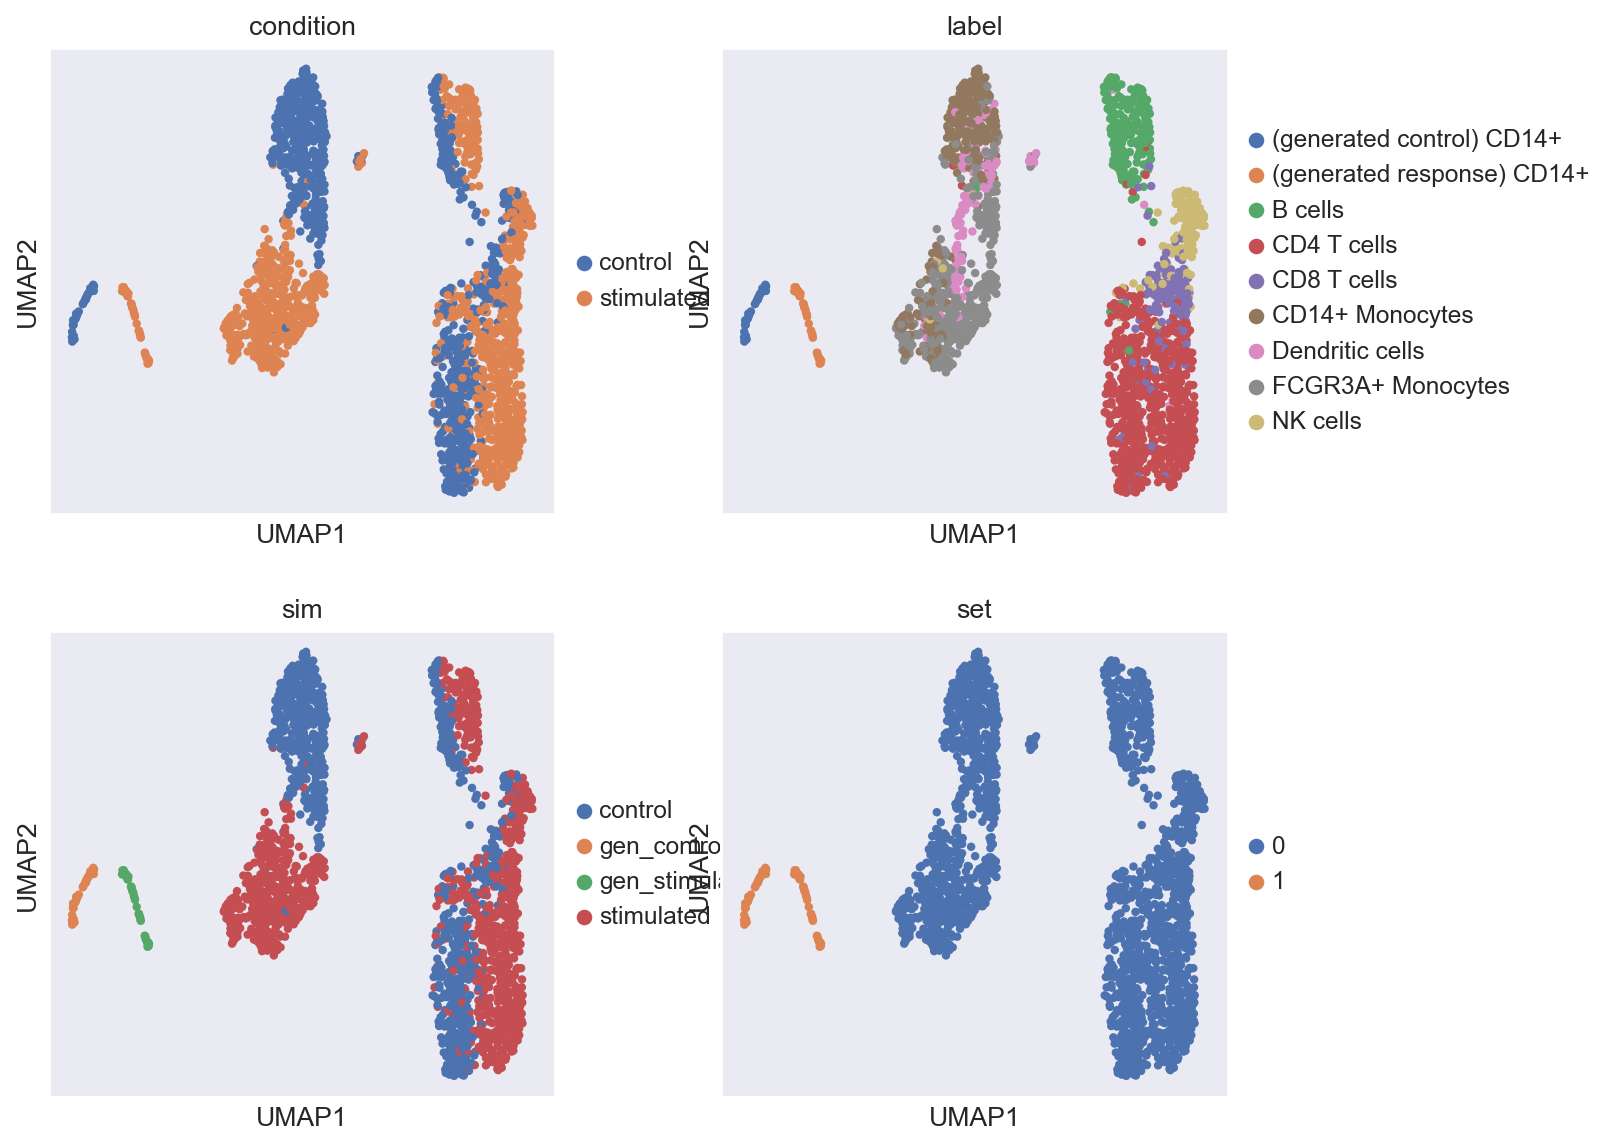

In [262]:
sc.pl.umap(xxdata,
           color=[
               "condition",
               "label",
               "sim",
               "set",
           ],
           ncols=2,
           save="Kang_generated_cd14_z_space.png",
          )


so in the z-space, the generated control cd14 cells land close to the real batch. The generated response cd14 constitute their own detached cluster.

In [263]:
sc.pp.pca(xxdata,)
sc.pp.neighbors(xxdata, )
sc.tl.umap(xxdata,)
sc.tl.louvain(xxdata,)

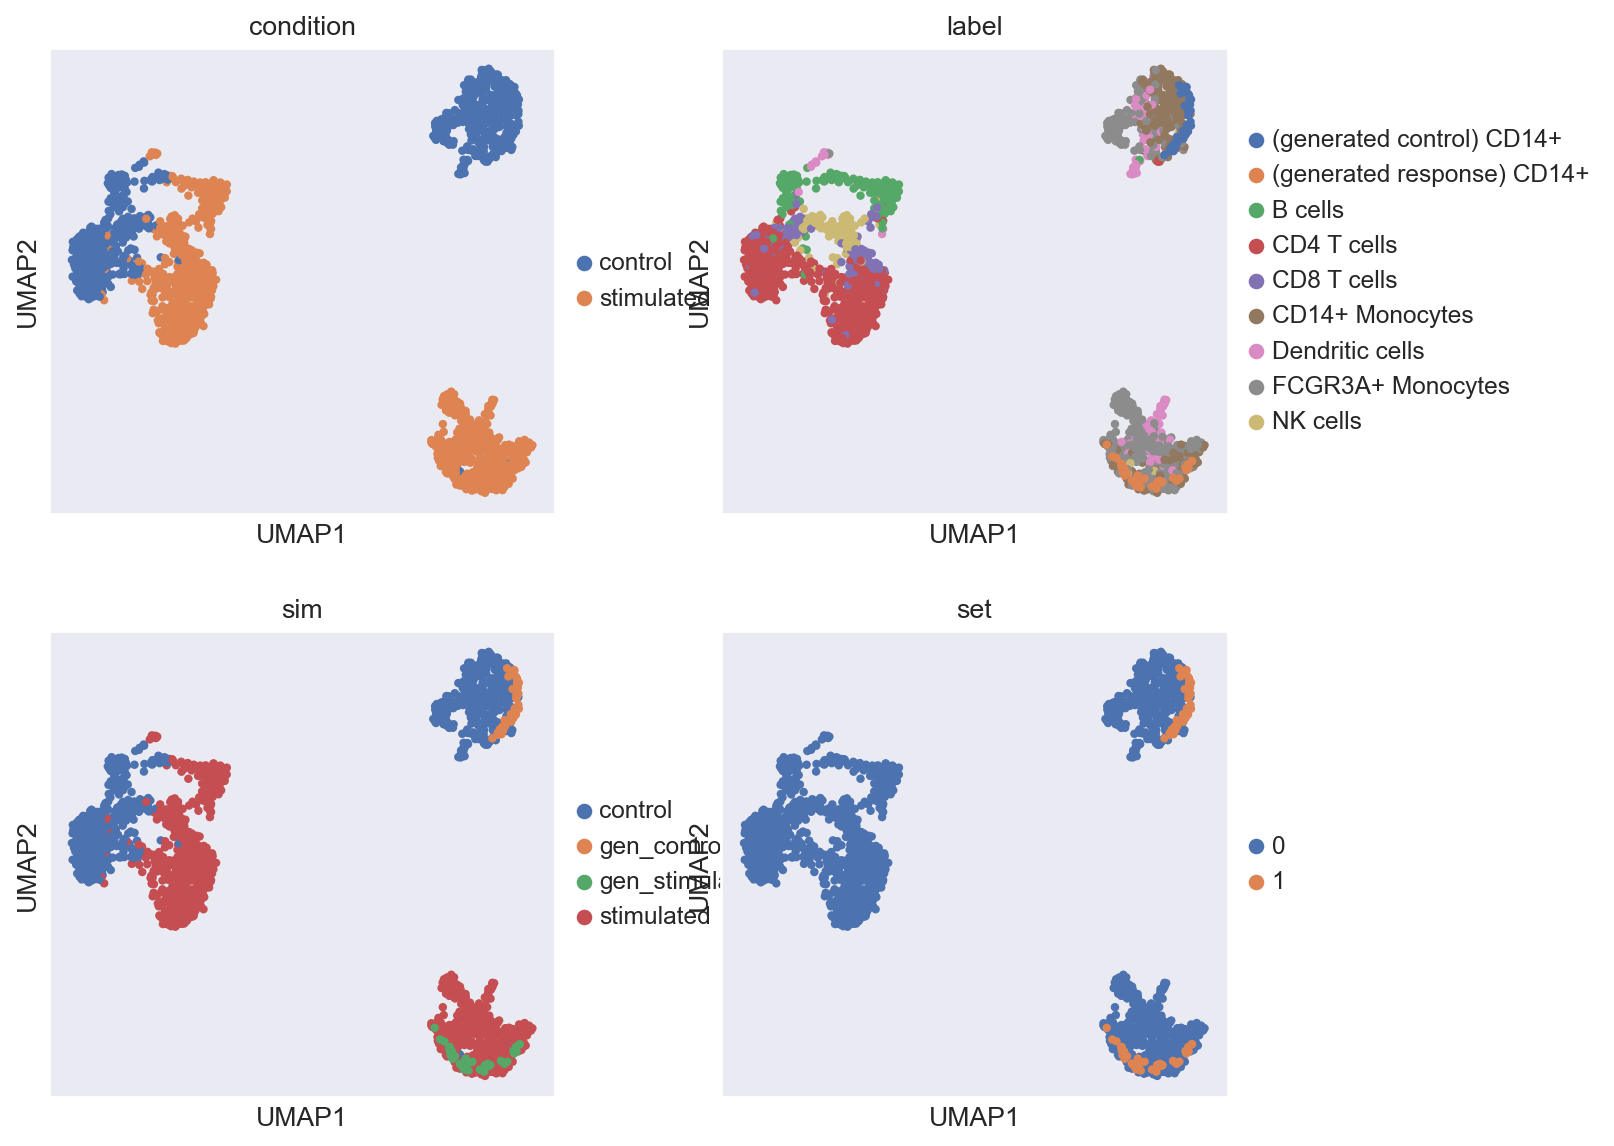

In [264]:
sc.pl.umap(xxdata,
           color=[
               "condition",
               "label",
               "sim",
               "set",
           ],
           ncols=2,
           save="Kang_generated_cd14_pca_space.png",
          )

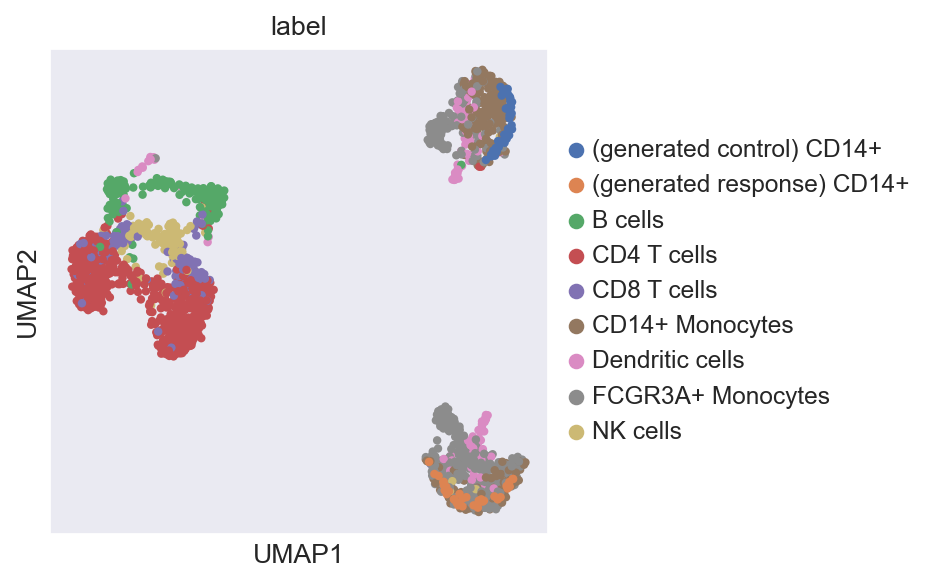

In [265]:
sc.pl.umap(xxdata,
           color=[
               #"condition",
               "label",
               #"sim",
               #"set",
           ],
           #ncols=2,
           save="Kang_generated_cd14_pca_space2.png",
          )


In the pca space, the generated data of the control cd14 cells is again mixed in pretty well with the real cd14 control data.
For the response (stimulated cells) there aren'y a lot of real cd14 response cells, but the generated data lands in the same
cluster as the real response cells and at least looks mixed or in the vicinity of the real data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


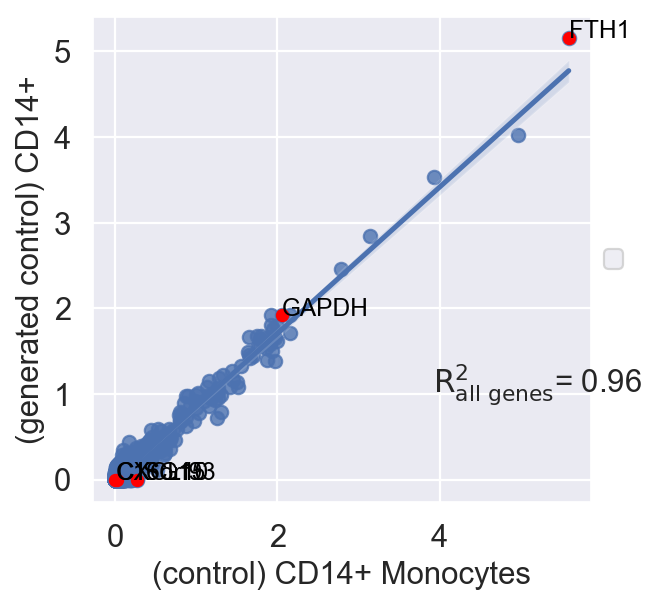

0.9587668861987817

In [266]:
ctrlmarker = xxdata.obs["condition"] == "control"
ut.reg_mean_plot(xxdata[ctrlmarker], show=True, condition_key="label",
                 axis_keys={"x" : "CD14+ Monocytes", "y" : "(generated control) CD14+"},
                 labels={"x" : "(control) CD14+ Monocytes", "y" : "(generated control) CD14+"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_gen_cd14_ctrl_real_cd14_ctrl.png",
                )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


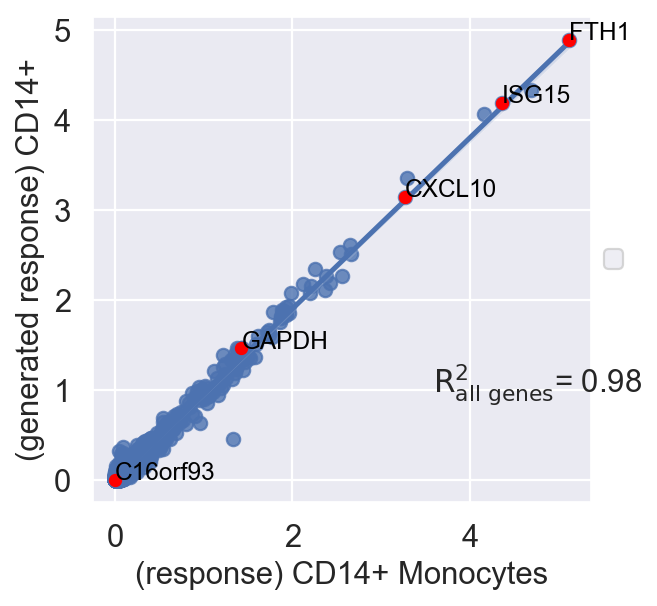

0.9835212188778856

In [267]:
ut.reg_mean_plot(xxdata[~ctrlmarker], show=True, condition_key="label",
                 axis_keys={"x" : "CD14+ Monocytes", "y" : "(generated response) CD14+"},
                 labels={"x" : "(response) CD14+ Monocytes", "y" : "(generated response) CD14+"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_gen_cd14_response_real_cd14_response.png",
                )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


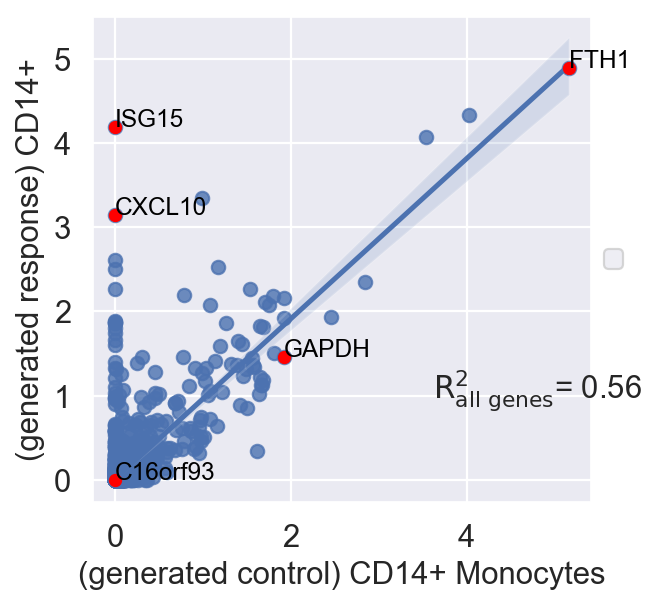

0.5645017894501513

In [281]:
ut.reg_mean_plot(xxdata, show=True, condition_key="label",
                 axis_keys={"x" : "(generated control) CD14+", "y" : "(generated response) CD14+"},
                 labels={"x" : "(generated control) CD14+ Monocytes", "y" : "(generated response) CD14+"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_gen_cd14_response_real_cd14_response.png",
                )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


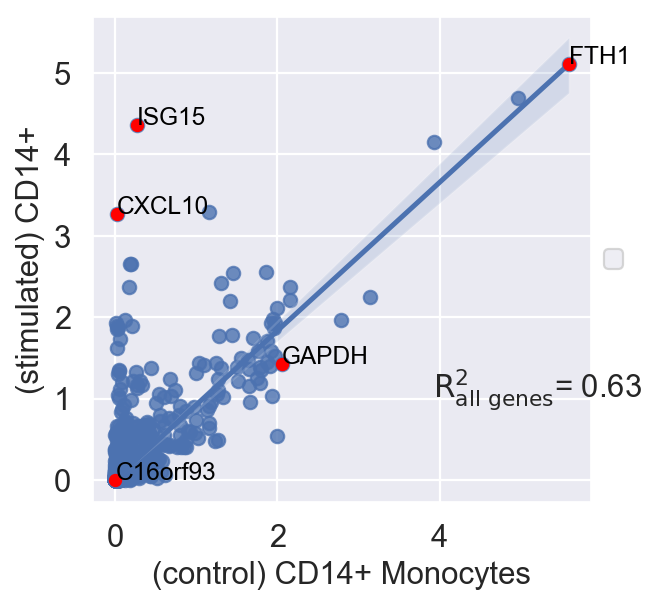

0.6276789945936868

In [283]:
marker = xxdata.obs["label"] == "CD14+ Monocytes"
ut.reg_mean_plot(xxdata[marker], show=True, condition_key="condition",
                 axis_keys={"x" : "control", "y" : "stimulated"},
                 labels={"x" : "(control) CD14+ Monocytes", "y" : "(stimulated) CD14+"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_gen_cd14_ctrl_real_cd14_ctrl.png",
                )


## Repeat with CD4 cells


In [268]:
ctrlMaerker = bdata.obs["condition"] == "control"
cd4Marker = bdata.obs["label"] == "CD4 T cells"

In [269]:
cdata = bdata[ctrlMaerker & cd4Marker].copy()
cdata.obs

cell_type condition  mt_frac  n_counts  n_genes  \
index                                                                           
CTTGATTGACTACG-1-control-0  CD4 T cells   control      0.0    2178.0      762   
GACTACGATCCTGC-1-control-0  CD4 T cells   control      0.0    1532.0      517   
ATATACGATCCCAC-1-control-0  CD4 T cells   control      0.0    1400.0      507   
ACATTCTGTCGCCT-1-control-0  CD4 T cells   control      0.0    1307.0      627   
ATAATGACACCTTT-1-control-0  CD4 T cells   control      0.0    1335.0      508   
...                                 ...       ...      ...       ...      ...   
GTAGGTACAGTGCT-1-control-0  CD4 T cells   control      0.0    1716.0      548   
TACAAATGGTGCAT-1-control-0  CD4 T cells   control      0.0    2400.0      820   
CGGCGAACTGCAAC-1-control-0  CD4 T cells   control      0.0    1757.0      588   
CATACTACCCGAAT-1-control-0  CD4 T cells   control      0.0    1486.0      555   
AGTAAGGATCTGGA-1-control-0  CD4 T cells   control      0.0    2336.0      936   

                            percent_mito       study      predict louvain  \
index                                                                       
CTTGATTGACTACG-1-control-0           NaN  Kang et al  CD4 T cells       4   
GACTACGATCCTGC-1-control-0           NaN  Kang et al  CD4 T cells       4   
ATATACGATCCCAC-1-control-0           NaN  Kang et al  CD4 T cells       4   
ACATTCTGTCGCCT-1-control-0           NaN  Kang et al  CD4 T cells       7   
ATAATGACACCTTT-1-control-0           NaN  Kang et al  CD4 T cells       7   
...                                  ...         ...          ...     ...   
GTAGGTACAGTGCT-1-control-0           NaN  Kang et al  CD4 T cells       4   
TACAAATGGTGCAT-1-control-0           NaN  Kang et al  CD4 T cells       7   
CGGCGAACTGCAAC-1-control-0           NaN  Kang et al  CD4 T cells       4   
CATACTACCCGAAT-1-control-0           NaN  Kang et al  CD4 T cells       7   
AGTAAGGATCTGGA-1-control-0           NaN  Kang et al  CD4 T cells       7   

                                  label      sim  
index                                             
CTTGATTGACTACG-1-control-0  CD4 T cells  control  
GACTACGATCCTGC-1-control-0  CD4 T cells  control  
ATATACGATCCCAC-1-control-0  CD4 T cells  control  
ACATTCTGTCGCCT-1-control-0  CD4 T cells  control  
ATAATGACACCTTT-1-control-0  CD4 T cells  control  
...                                 ...      ...  
GTAGGTACAGTGCT-1-control-0  CD4 T cells  control  
TACAAATGGTGCAT-1-control-0  CD4 T cells  control  
CGGCGAACTGCAAC-1-control-0  CD4 T cells  control  
CATACTACCCGAAT-1-control-0  CD4 T cells  control  
AGTAAGGATCTGGA-1-control-0  CD4 T cells  control  

[295 rows x 11 columns]

In [270]:
model.cpu()
model.eval()
simOutput = model(
    input=test_data[ctrlMaerker & cd4Marker],
    y=test_labels[ctrlMaerker & cd4Marker],
    cond1=1-test_conditions[ctrlMaerker & cd4Marker],
)

In [271]:
cdata.X = simOutput['rec'].detach().abs().numpy()
cdata.obsm["z"] = simOutput["mu_z"].detach().numpy()
cdata.obsm["mu_w"] = simOutput["mu_w"].detach().numpy()
cdata.obsm["w"] = simOutput["w"].detach().numpy()
cdata.obs["sim"] = "simulated"
bdata.obs["sim"] = bdata.obs["condition"].copy()

In [272]:
xdata = ad.concat([bdata, cdata], label="set", join="inner",)
xdata.var_names_make_unique()
xdata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [273]:
sc.pp.neighbors(xdata,use_rep="z")
sc.tl.umap(xdata, )
sc.tl.louvain(xdata,)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

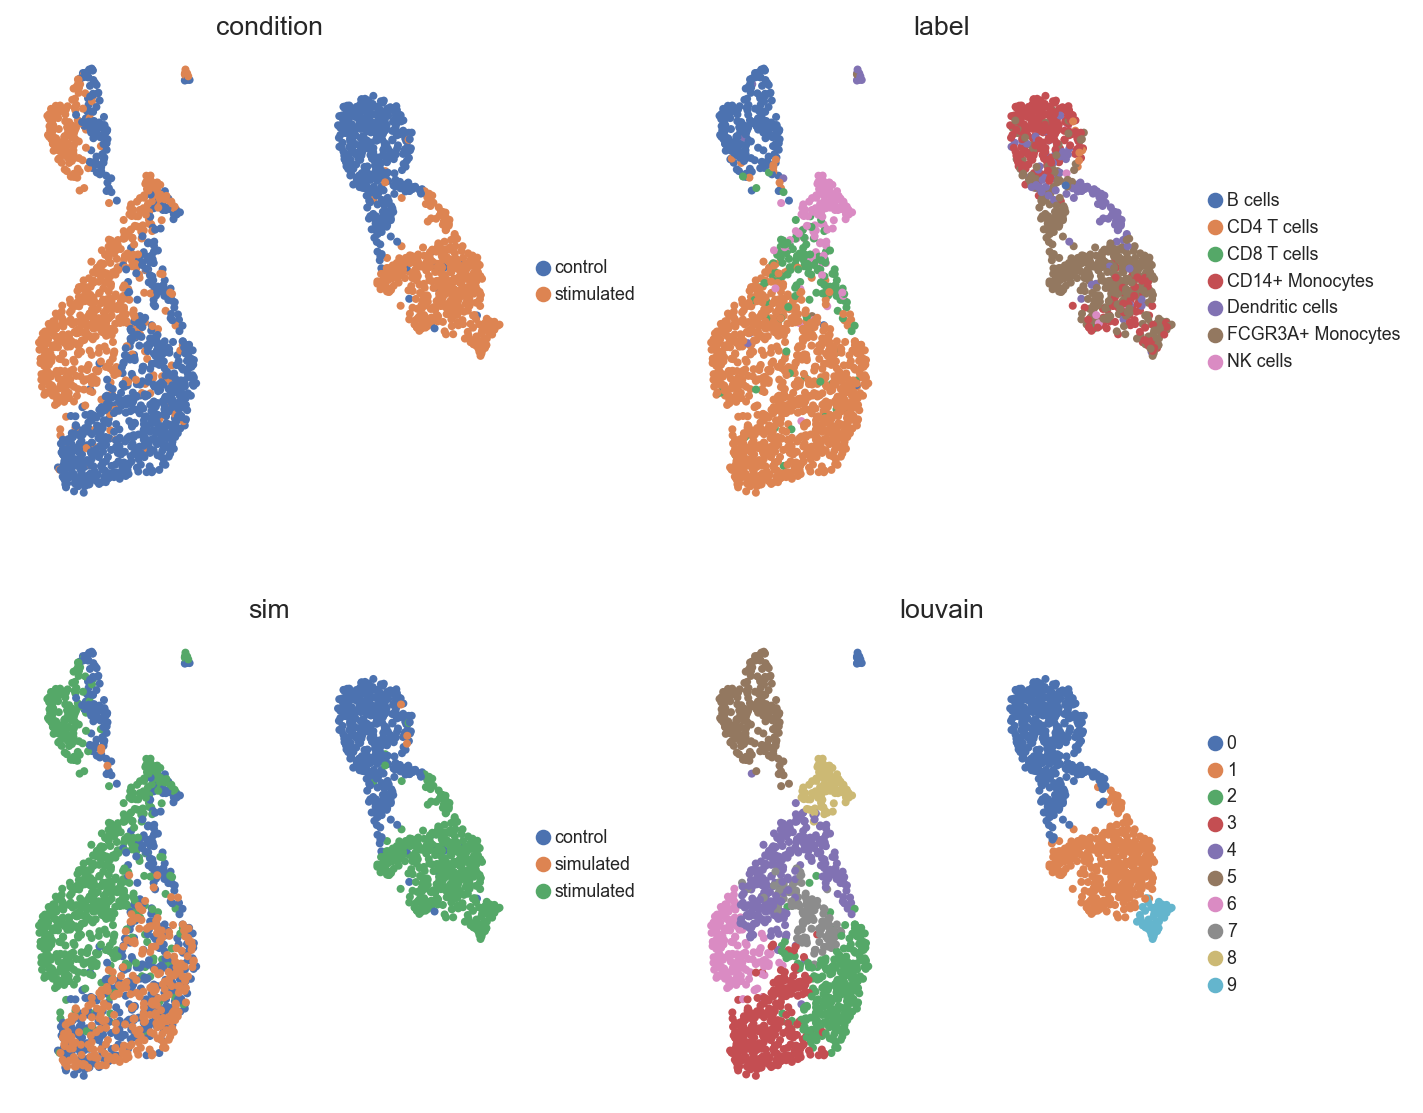

In [274]:
sc.pl.umap(xdata,
           color=[
               "condition",
               "label",
               "sim",
               "louvain",
           ], 
           frameon=False,
           #legend_loc='on data',
           legend_fontsize=8,
           ncols=2,
           #color_map="magma",
           #save="Kang_simulated_response_cd14_z_space.png",
          )

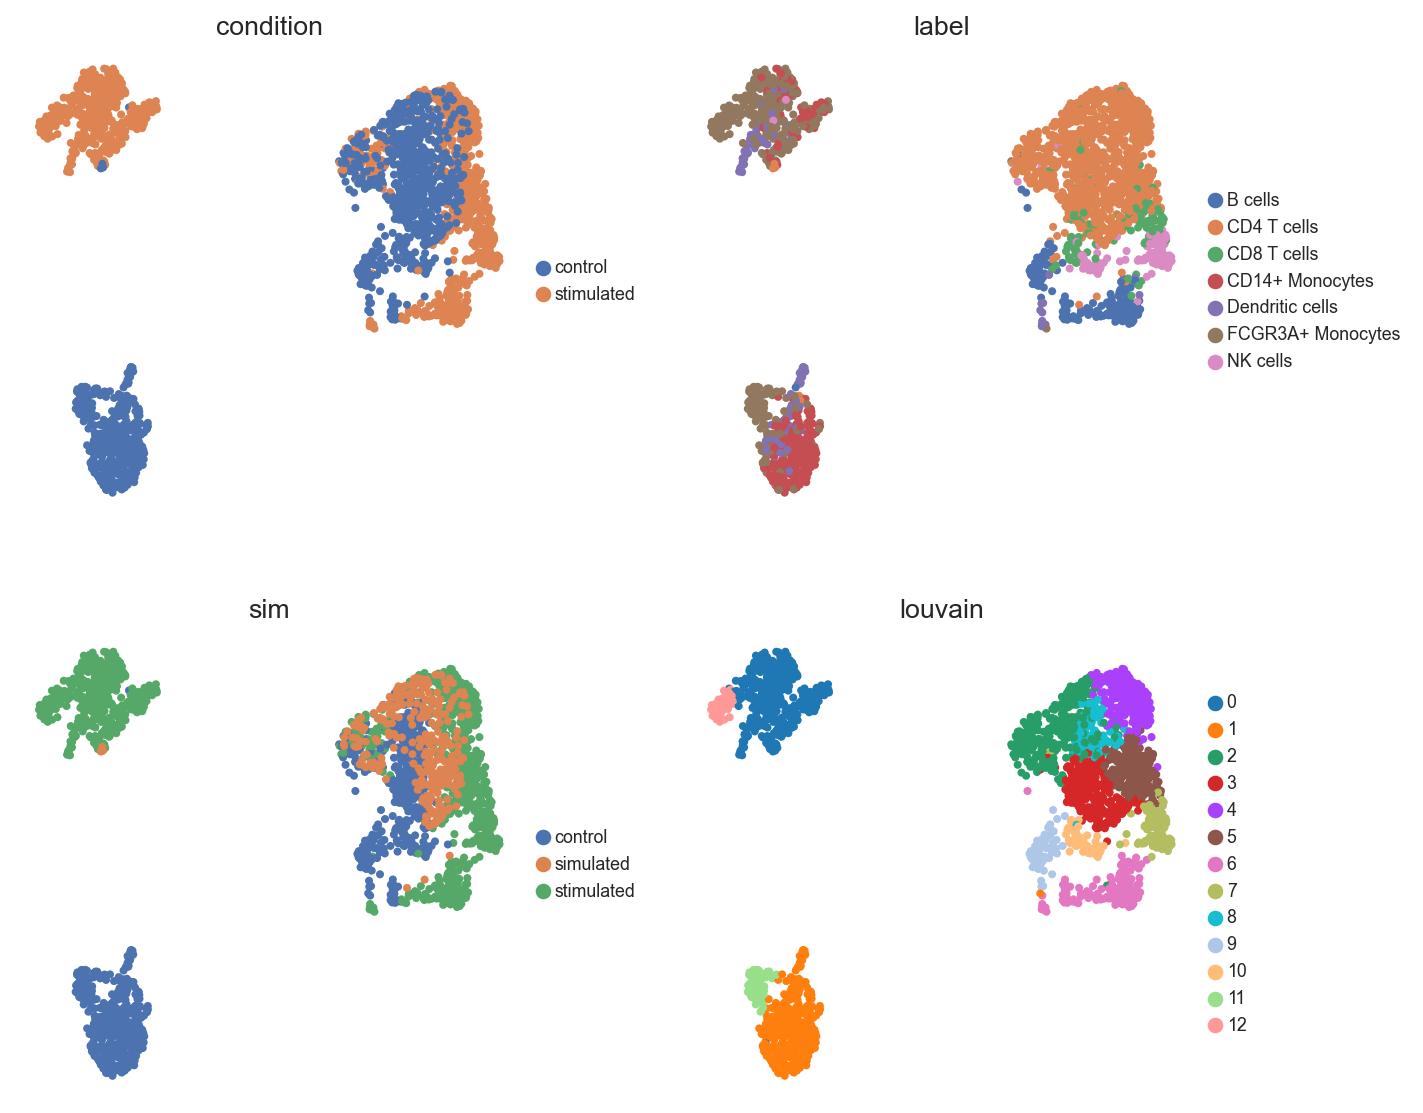

In [275]:
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata,)
sc.tl.umap(xdata, )
sc.tl.louvain(xdata,)
sc.pl.umap(xdata,
           color=[
               "condition",
               "label",
               "sim",
               "louvain",
           ], 
           frameon=False,
           #legend_loc='on data',
           legend_fontsize=8,
           ncols=2,
           #color_map="magma",
           #save="Kang_simulated_response_cd14_z_space.png",
          )

In [276]:
ydata = xdata[xdata.obs["label"] == "CD4 T cells"].copy()
ydata

AnnData object with n_obs × n_vars = 978 × 7000
    obs: 'cell_type', 'condition', 'mt_frac', 'n_counts', 'n_genes', 'percent_mito', 'study', 'predict', 'louvain', 'label', 'sim', 'set'
    uns: 'neighbors', 'umap', 'louvain', 'condition_colors', 'label_colors', 'sim_colors', 'louvain_colors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'mu_z', 'z', 'mu_w', 'w'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


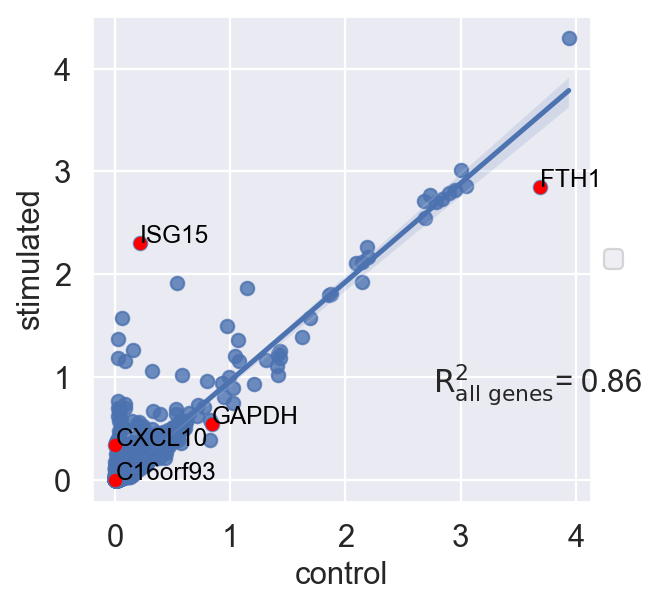

0.8620991657363997

In [277]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "control", "y" : "stimulated"},
                 labels={"x" : "control", "y" : "stimulated"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_ctrl_resp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


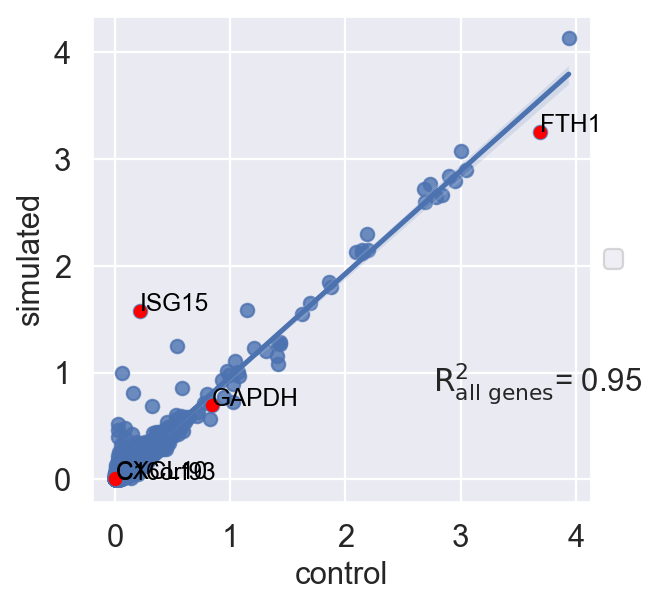

0.9512919557960264

In [278]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "control", "y" : "simulated"},
                 labels={"x" : "control", "y" : "simulated"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_ctrl_simresp.png",
                )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


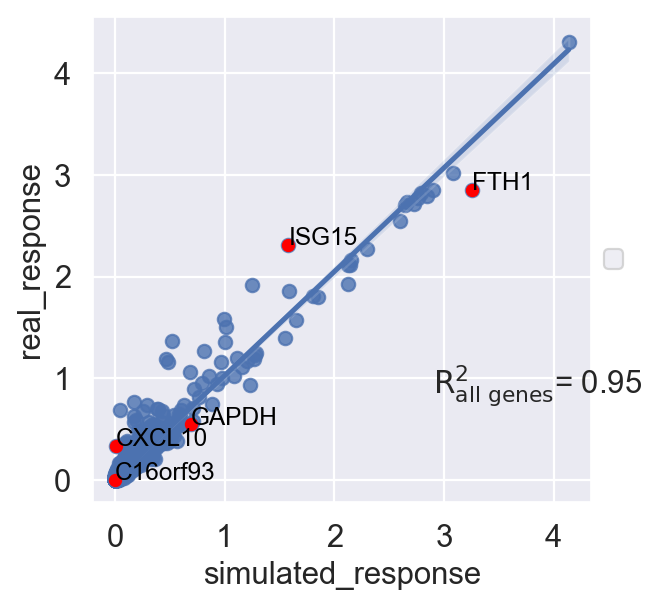

0.9528056712162173

In [279]:
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "simulated", "y" : "stimulated"},
                 labels={"x" : "simulated_response", "y" : "real_response"},
                 gene_list=["FTH1", "GAPDH","ISG15","CXCL10","C16orf93",],
                 save="Kang_reg_resp_simresp.png",
                )